# Regenerate Textual Embedding


In [ ]:
# from transformers import AutoTokenizer, AutoModel
# import torch
# import numpy as np

# # Replace with the appropriate BioBERT model name
# model_name = 'dmis-lab/biobert-v1.1'

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)

# class_descriptions = [
#     "Normal eye condition",
#     "Diabetes related eye disease",
#     "Glaucoma eye condition",
#     "Cataract eye disease",
#     "Age-related macular degeneration",
#     "Hypertension related eye disease",
#     "Pathological Myopia eye condition",
#     "Other eye diseases"
# ]

# embeddings = []
# for description in class_descriptions:
#     inputs = tokenizer(description, return_tensors="pt", padding=True, truncation=True)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     # Use the last hidden state as the embedding
#     embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
#     embeddings.append(embedding)

# # Convert to a NumPy array
# textual_embeddings_8_classes = np.array(embeddings)

# BIOBERT_PATH = "/content/drive/MyDrive/dlh/biobert/odir5k.npy"
# np.save(BIOBERT_PATH, textual_embeddings_8_classes)


# Dataset Preparation

## Prepare Dataset Class


In [ ]:
import os

import numpy as np
from PIL import Image
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import glob

DATASET_ROOT = "/content/drive/MyDrive/dlh"
NUM_CLASSES = 8


class Odir5K(Dataset):
    def __init__(self, transform, split_type='train', classes_to_load='seen', exclude_all=True):
        self._data_path = DATASET_ROOT

        self.transform = transform

        self.split_type = split_type

        # class
        # N D G C A H M O
        self.CLASSES = ["Normal", "Diabetes", "Glaucoma", "Cataract", "Age Related Maculare Degeneration", "Hypertension", "Pathological Myopia", "Other"]
        self.num_classes = len(self.CLASSES)
        self.seen_classes = ["Normal", "Diabetes", "Glaucoma", "Cataract", "Hypertension", "Pathological Myopia", "Other"]
        self.unseen_classes = ["Age Related Maculare Degeneration"]

        self._class_ids = {v: i for i, v in enumerate(self.CLASSES) if v != 'No Finding'}
        self.seen_class_ids = [self._class_ids[label] for label in self.seen_classes]
        self.unseen_class_ids = [self._class_ids[label] for label in self.unseen_classes]

        # args
        self.classes_to_load = classes_to_load
        self.exclude_all = exclude_all


        # additional prop to be created during construct index
        self.names_to_path = {}
        self.class_ids_loaded = []
        self._imdb = []

        self._construct_index()

    def _construct_index(self):
        # Create a map of all available images
        paths = glob.glob(os.path.join(self._data_path, f"{self.split_type}/*.jpg"))
        # key: filename, value: path
        self.names_to_path = {path.split('/')[-1]: path for path in paths}
        # print(list(self.names_to_path.keys()))

        # data_entry_file = 'Data_Entry_2017.csv'
        # split_path = os.path.join(self._data_path, self._split)

        # read all filenames of this split
        # split_path = os.path.join(self._data_path, "split", f"{self.split_type}.txt")
        # print(f'split path: {split_path}')
        # with open(split_path, 'r') as f:
        #   file_names = f.readlines()

        # list of all filename in this split
        # e.q. ['00000003_000.png', '00000003_000.png', '00000003_000.png', ...]
        # split_file_names = np.array([file_name.strip().split(' ')[0].split('/')[-1] for file_name in file_names])

        df = pd.read_csv(f'{self._data_path}/full_df.csv')
        image_index = df.iloc[:, 18].values
        # print(image_index)

        _, split_index, _ = np.intersect1d(image_index, list(self.names_to_path.keys()), return_indices=True)

        # print(split_index)


        # target labels
        target_label = [self._convert_label_to_indices(label) for label in df.iloc[:, 17].values]
        # print(labels)

        labels_n = df.iloc[:, 7]
        # print(labels_n)
        labels_d = df.iloc[:, 8]
        labels_g = df.iloc[:, 9]
        labels_c = df.iloc[:, 10]
        labels_a = df.iloc[:, 11]
        labels_h = df.iloc[:, 12]
        labels_m = df.iloc[:, 13]
        labels_o = df.iloc[:, 14]

        # Construct the image db
        self._imdb = []
        self.class_ids_loaded = []

        max_labels = 0
        # for every filename
        for index in split_index:

            # get class ids from the stringlabel
            multi_labels = [
                int(labels_n[index]),
                int(labels_d[index]),
                int(labels_g[index]),
                int(labels_c[index]),

                int(labels_a[index]),
                int(labels_h[index]),
                int(labels_m[index]),
                int(labels_o[index])
            ]
            class_ids = [i for i, value in enumerate(multi_labels) if value == 1]
            # print(class_ids)

            # if should not load, then don't
            if not self._should_load_image(class_ids):
                continue

            # add the loaded class ids to the list
            self.class_ids_loaded += class_ids

            # SKIP if the image is not downloaded, we only use subset
            # if not image_index[index] in self.names_to_path:
                # print(f"Skipping {image_index[index]}")
                # continue

            # append the image db
            # print(image_index[index])
            self._imdb.append({
                'im_path': self.names_to_path[str(image_index[index])],
                'labels': class_ids,
                'target_label': target_label[index]
            })
            max_labels = max(max_labels, len(class_ids))

        self.class_ids_loaded = np.unique(np.array(self.class_ids_loaded))
        print(f'Number of images: {len(self._imdb)}')
        print(f'Max Number of labels per image: {max_labels}')
        print(f'Number of classes: {len(self.class_ids_loaded)}')
        print(self.class_ids_loaded)

    def _should_load_image(self, labels):
        # always load if we want to load everything
        # print(labels)
        if self.classes_to_load == 'all':
            return True

        if self.classes_to_load == 'seen':
            selected_class_labels = self.seen_class_ids
        elif self.classes_to_load == 'unseen':
            selected_class_labels = self.unseen_class_ids
        else:
          raise Exception(f"Invalid classes_to_load {self.classes_to_load}")

        count = 0
        for label in labels:
            if label in selected_class_labels:
                count+=1

        if count == len(labels):
            # all labels from selected sub set
            return True
        elif count == 0:
            # none label in selected sub set
            return False

        # if partial match
        return not self.exclude_all

    def __getitem__(self, index):
        # get image
        imagePath = self._imdb[index]['im_path']
        imageData = Image.open(imagePath).convert('RGB')
        img = self.transform(imageData)

        # get labels
        labels = torch.tensor(self._imdb[index]['labels'])
        labels = labels.unsqueeze(0)
        imageLabel = torch.zeros(labels.size(0), self.num_classes).scatter_(1, labels, 1.).squeeze()

        return img, imageLabel

    def __len__(self):
        return len(self._imdb)

    def _convert_label_to_indices(self, label_string):
        """Converts a label string to a list of indices.

        Args:
            label_string: The label string, e.g., '[1, 0, 0, 1, 0, 1, 0, 0]'.

        Returns:
            A list of indices where the value is 1, e.g., [0, 3, 5].
        """
        # print(label_string)
        # Remove brackets and split the string into individual values
        label_values = label_string.strip('[]').split(', ')

        # Convert values to integers and find indices where value is 1
        indices = [i for i, value in enumerate(label_values) if value == "1"]

        return indices[0]




In [ ]:
def get_test_transforms(resize=256, crop=224):
  test_transforms = []
  normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

  test_transforms.append(transforms.Resize(resize))
  test_transforms.append(transforms.TenCrop(crop))
  test_transforms.append(
      transforms.Lambda(
          lambda crops: torch.stack(
              [transforms.ToTensor()(crop) for crop in crops]
          )
      )
  )
  test_transforms.append(
      transforms.Lambda(
          lambda crops: torch.stack([normalize(crop) for crop in crops])
      )
  )

  return transforms.Compose(test_transforms)

def get_train_transforms(resize=256, crop=224):
  train_transforms = []

  normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

  train_transforms = []
  train_transforms.append(transforms.RandomResizedCrop(crop))
  train_transforms.append(transforms.RandomHorizontalFlip())
  train_transforms.append(transforms.ToTensor())
  train_transforms.append(normalize)

  return transforms.Compose(train_transforms)


In [ ]:
# initialize the dataset
test_transforms = get_test_transforms()
test_dataset = Odir5K(test_transforms, split_type="test", classes_to_load="all")

val_dataset = Odir5K(test_transforms, split_type="test")

train_transforms = get_train_transforms()
train_dataset = Odir5K(train_transforms, split_type="train")

Number of images: 1259
Max Number of labels per image: 3
Number of classes: 8
[0 1 2 3 4 5 6 7]
Number of images: 1194
Max Number of labels per image: 3
Number of classes: 7
[0 1 2 3 5 6 7]
Number of images: 4880
Max Number of labels per image: 3
Number of classes: 7
[0 1 2 3 5 6 7]


In [ ]:
df = pd.read_csv(f'{DATASET_ROOT}/full_df.csv')
df.head(100)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,114,48,Male,114_left.jpg,114_right.jpg,spotted membranous change，spotted membranous c...,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",114_right.jpg
96,115,66,Female,115_left.jpg,115_right.jpg,vitreous degeneration,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",115_right.jpg
97,116,61,Male,116_left.jpg,116_right.jpg,hypertensive retinopathy,hypertensive retinopathy,0,0,0,0,0,1,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['H'],"[0, 0, 0, 0, 0, 1, 0, 0]",116_right.jpg
98,117,65,Female,117_left.jpg,117_right.jpg,normal fundus,epiretinal membrane,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",117_right.jpg


Data Visualization

In [ ]:
len(train_dataset)

4880

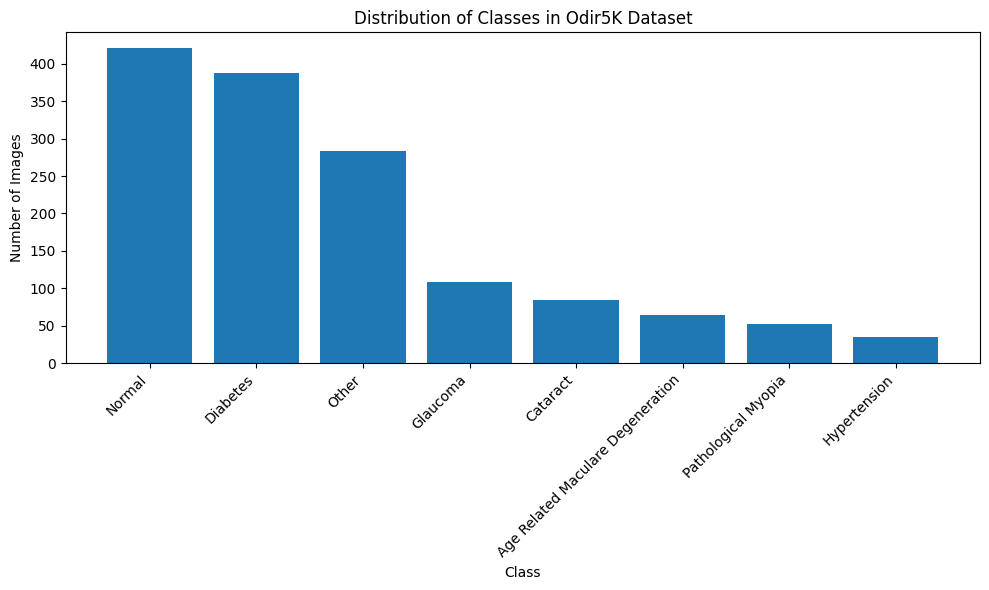

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

labels = [test_dataset._imdb[i]['labels'] for i in range(len(test_dataset))]
class_names = test_dataset.CLASSES

flat_labels = [item for sublist in labels for item in sublist]
label_counts = pd.DataFrame(flat_labels, columns=['class_id']).class_id.value_counts()

df = pd.DataFrame({'Class': [class_names[i] for i in label_counts.index], 'Count': label_counts.values})

plt.figure(figsize=(10, 6))
plt.bar(df['Class'], df['Count'])  # Create the bar plot
plt.title('Distribution of Classes in Odir5K Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

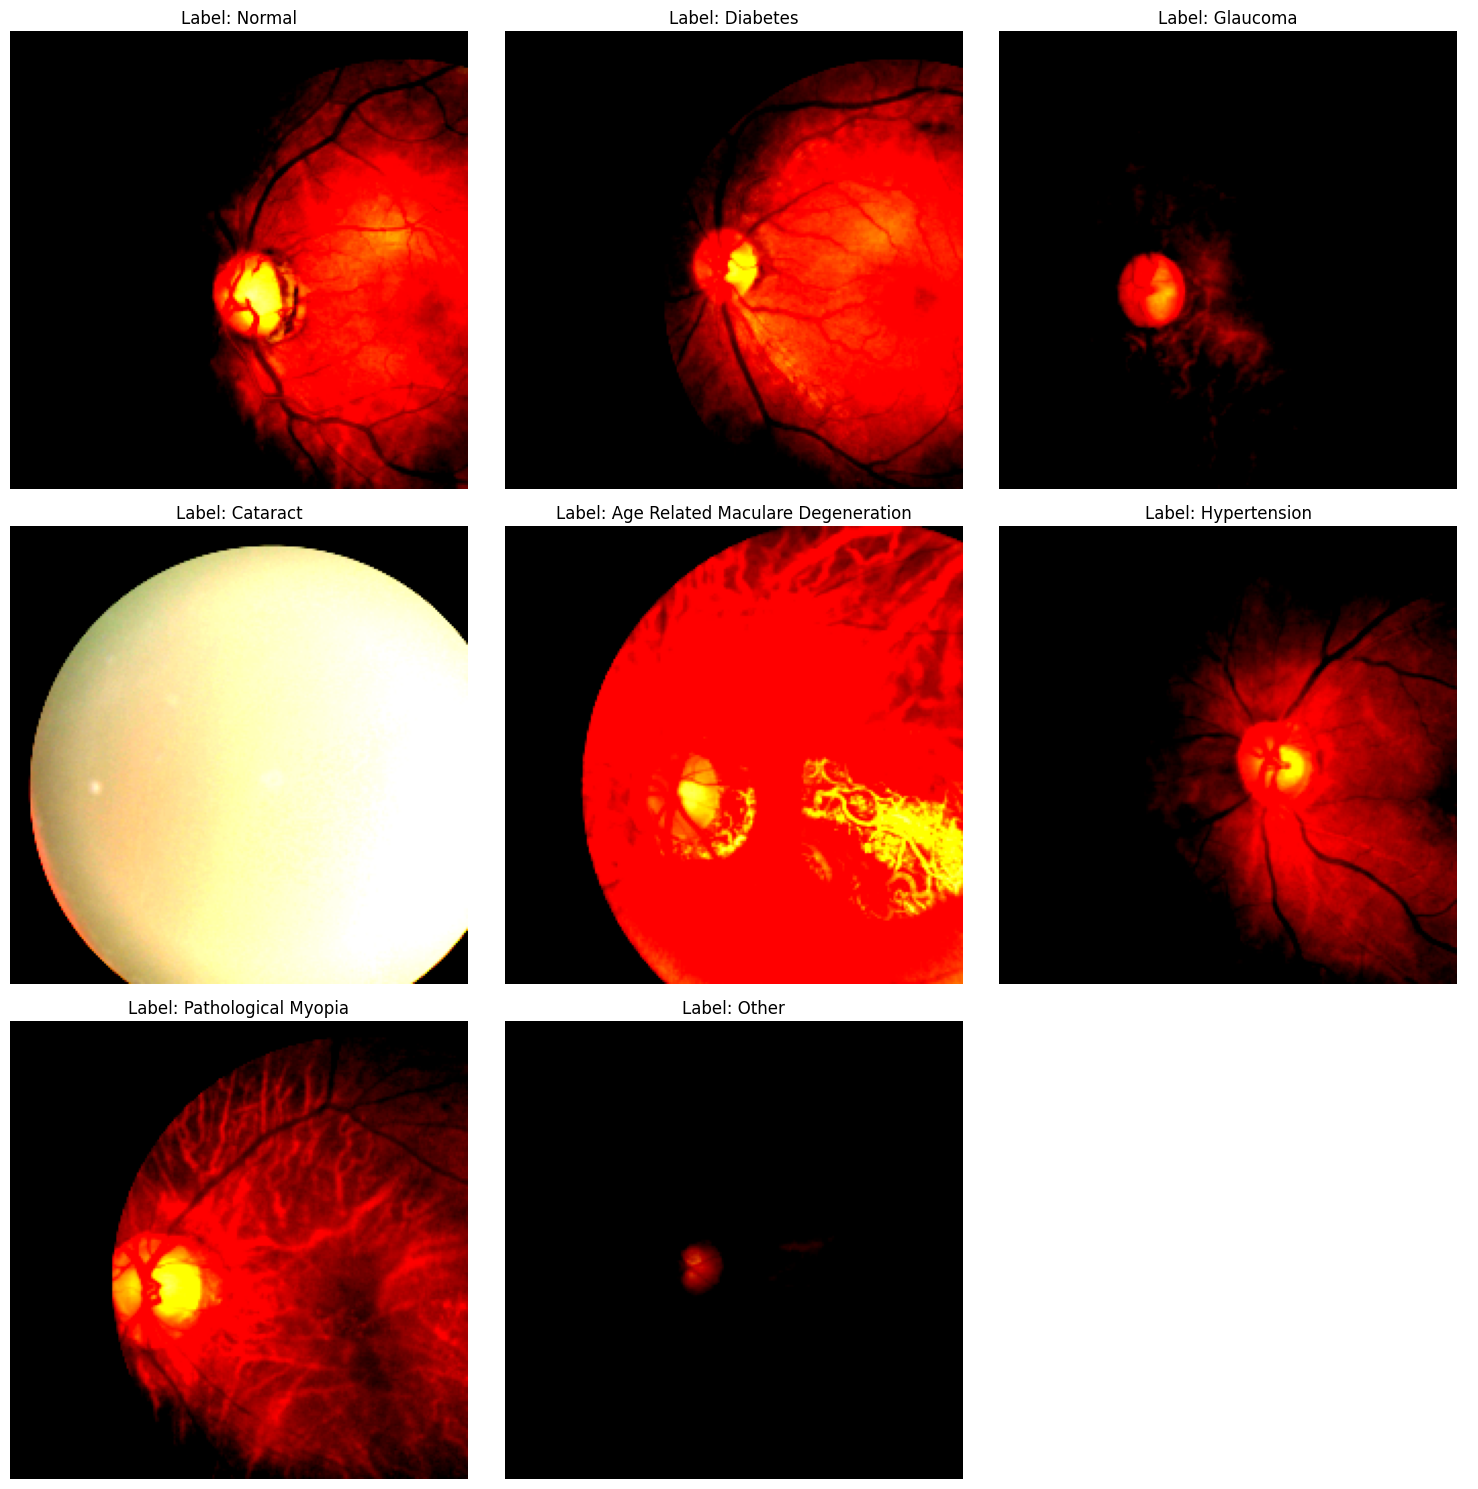

In [ ]:
# Create a dictionary to store an example image for each label
label_examples = {}

# Iterate through the dataset and find an example for each label
for i in range(len(test_dataset)):
    label = test_dataset._imdb[i]['labels'][0]  # Get the label for the current image
    if label not in label_examples:
        label_examples[label] = test_dataset[i][0]  # Store the image if it's the first example for this label

# Plot the example images for each label
unique_labels = np.unique([test_dataset._imdb[i]['labels'][0] for i in range(len(test_dataset))])  # Assuming single label per image
# Calculate the number of rows and columns for the grid
num_rows = 3
num_cols = 3

# Create a figure and axes for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))  # Adjust figsize as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the unique labels and display images in the grid
for i, label in enumerate(unique_labels):
    if i >= len(axes):  # Break if we've filled all grid cells
        break

    # Select the first crop from the tensor
    image = label_examples[label][0]  # or label_examples[label][0, ...]

    # Display the image
    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].set_title(f"Label: {test_dataset.CLASSES[label]}")
    axes[i].axis('off')

# Hide any unused axes in the grid
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as LA
from torch.nn.functional import kl_div, softmax, log_softmax

class CosineLoss(nn.Module):
    """
    CosineLoss is a custom loss function that measures the similarity between
    two embeddings using the cosine similarity metric. It is used to align
    embeddings from different modalities (e.g., textual and visual embeddings)
    in a shared space.

    Methods:
        forward(t_emb, v_emb):
            Computes the cosine loss between textual and visual embeddings.

    Forward Args:
        t_emb (torch.Tensor): Textual embeddings (batch_size x embedding_dim).
        v_emb (torch.Tensor): Visual embeddings (batch_size x embedding_dim).

    Returns:
        torch.Tensor: The computed cosine loss as a scalar value.
    """
    def forward(self, t_emb, v_emb ):
        a_norm = v_emb / v_emb.norm(dim=1)[:, None]
        b_norm = t_emb / t_emb.norm(dim=1)[:, None]
        loss = 1 - torch.mean(torch.diagonal(torch.mm(a_norm, b_norm.t()), 0))

        return loss

In [ ]:
class RankingLoss(nn.Module):
    """
    RankingLoss is a custom loss function designed to enforce a ranking order
    between positive and negative samples. It ensures that the scores for
    correct labels are higher than those for incorrect labels by a margin.

    Attributes:
        neg_penalty (float): The margin penalty applied to incorrect labels
                             that score higher than correct labels.

    Methods:
        forward(ranks, labels, class_ids_loaded, device):
            Computes the ranking loss for the given predictions and labels.

    Args:
        neg_penalty (float, optional): The margin penalty for incorrect labels.
                                       Default is 0.03.

    Forward Args:
        ranks (torch.Tensor): Predicted scores for each class (batch_size x num_classes).
        labels (torch.Tensor): Ground truth labels (binary, batch_size x num_classes).
        class_ids_loaded (list): Indices of the classes being considered.
        device (torch.device): Device for computation (CPU/GPU).

    Returns:
        torch.Tensor: The computed ranking loss as a scalar value.
    """

    def __init__(self, neg_penalty=0.03):
        super(RankingLoss, self).__init__()
        self.neg_penalty = neg_penalty

    def forward(self, ranks, labels, class_ids_loaded, device):
        '''
        for each correct it should be higher then the absence
        '''

        labels = labels[:, class_ids_loaded]
        ranks_loaded = ranks[:, class_ids_loaded]

        neg_labels = 1+(labels*-1)
        loss_rank = torch.zeros(1).to(device)

        for i in range(len(labels)):
            correct = ranks_loaded[i, labels[i]==1]
            wrong = ranks_loaded[i, neg_labels[i]==1]

            # print(correct)
            # print(wrong)

            try:
                correct = correct.reshape((-1, 1)).repeat((1, len(wrong)))
                wrong = wrong.repeat(len(correct)).reshape(len(correct), -1)

                image_level_penalty = ((self.neg_penalty+wrong) - correct)
                image_level_penalty[image_level_penalty<0] = 0
                loss_rank += image_level_penalty.sum()
            except Exception as e:
                print(correct)
                print(wrong)
                raise e

        loss_rank /= len(labels)

        return loss_rank

In [ ]:
import torch.nn as nn
import torchvision
import torch

VISION_BACKBONE = "densenet121"
LAST_CHECKPOINT_PATH = "/content/drive/MyDrive/dlh/checkpoints/bak_best_auroc_checkpoint.pth.tar"


class ZSLNet(nn.Module):
    def __init__(self, textual_embeddings=None, device="cpu"):

        super(ZSLNet, self).__init__()
        self.device = device
        self.vision_backbone = torchvision.models.densenet121(pretrained=True)

        # default args
        # Without Consistency Regularizer Loss):
        """
        Purpose: This argument disables the semantic consistency regularizer loss during training.
        The consistency regularizer ensures that the similarity between textual embeddings remains
        consistent before and after mapping to the shared space.
        """
        self.wo_con = False

        """
        Without Alignment Loss
        his argument disables the alignment loss during training.
        The alignment loss ensures that the mapped visual and textual
        embeddings are aligned in the shared space.
        """
        self.wo_map = False

        # default hyper param
        self.beta_map = 0.1
        self.beta_con = 0.1
        self.beta_rank = 1
        self.neg_penalty = 0.03

        # bce only
        """
        Binary Cross-Entropy Only Training
        This flag enables training the model using only the Binary Cross-Entropy
        (BCE) loss. When this flag is set, the model does not use the ranking
        loss, cosine loss, or other advanced loss functions.
        """
        self.bce_only = False

        # remove classification layer from visual encoder
        classifiers = ["classifier", "fc"]
        for classifier in classifiers:
            cls_layer = getattr(self.vision_backbone, classifier, None)
            if cls_layer is None:
                continue
            d_visual = cls_layer.in_features
            setattr(self.vision_backbone, classifier, nn.Identity(d_visual))
            break

        pretrained_encoder = False
        if pretrained_encoder:
            self.vision_backbone.classifier = nn.Identity(d_visual)

            self.classifier = nn.Sequential(
                nn.Linear(d_visual, NUM_CLASSES), nn.Sigmoid()
            )
            checkpoint = torch.load(LAST_CHECKPOINT_PATH)
            self.load_state_dict(checkpoint["state_dict"])

            for p in self.vision_backbone.parameters():
                p.requires_grad = False

        if self.bce_only:
            self.bce_loss = torch.nn.BCELoss(size_average=True)
            self.classifier = nn.Sequential(
                nn.Linear(d_visual, NUM_CLASSES), nn.Sigmoid()
            )
        else:
            self.emb_loss = CosineLoss()
            self.ranking_loss = RankingLoss(neg_penalty=self.neg_penalty)
            self.textual_embeddings = textual_embeddings
            d_textual = self.textual_embeddings.shape[-1]

            self.textual_embeddings = torch.from_numpy(self.textual_embeddings).to(
                self.device
            )

            self.fc_v = nn.Sequential(
                nn.Linear(d_visual, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
            )

            self.fc_t = nn.Sequential(
                nn.Linear(d_textual, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
            )

    def forward(self, x, labels=None, epoch=0, n_crops=0, bs=16):
        if self.bce_only:
            return self.forward_bce_only(x, labels=labels, n_crops=n_crops, bs=bs)
        else:
            return self.forward_ranking(
                x, labels=labels, epoch=epoch, n_crops=n_crops, bs=bs
            )

    def forward_bce_only(self, x, labels=None, n_crops=0, bs=16):
        lossvalue_bce = torch.zeros(1).to(self.device)

        visual_feats = self.vision_backbone(x)
        preds = self.classifier(visual_feats)

        if labels is not None:
            lossvalue_bce = self.bce_loss(preds, labels)

        return preds, lossvalue_bce, f"bce:\t {lossvalue_bce.item():0.4f}"

    def forward_ranking(self, x, labels=None, epoch=0, n_crops=0, bs=16):
        loss_rank = torch.zeros(1).to(self.device)
        loss_allignment_cos = torch.zeros(1).to(self.device)
        loss_mapping_consistency = torch.zeros(1).to(self.device)

        visual_feats = self.vision_backbone(x)
        visual_feats = self.fc_v(visual_feats)
        text_feats = self.fc_t(self.textual_embeddings)

        if not self.wo_con and epoch >= 0:
            text_mapped_sim = self.sim_score(text_feats, text_feats.detach())
            text_orig_sim = self.sim_score(
                self.textual_embeddings, self.textual_embeddings
            )
            loss_mapping_consistency = torch.abs(text_orig_sim - text_mapped_sim).mean()

        if labels is not None:
            # print(labels, text_feats)
            mapped_visual, mapped_text = self.map_visual_text(
                visual_feats, labels, text_feats
            )
            if mapped_visual is not None and not self.wo_map and epoch >= 0:
                loss_allignment_cos = self.emb_loss(mapped_text, mapped_visual)

        ranks = self.sim_score(visual_feats, text_feats)
        if n_crops > 0:
            ranks = ranks.view(bs, n_crops, -1).mean(1)

        if labels is not None:
            loss_rank = self.ranking_loss(
                ranks, labels, self.class_ids_loaded, self.device
            )
        # loss_allignment_cos = self.beta_map * loss_allignment_cos
        loss_rank = self.beta_rank * loss_rank
        loss_mapping_consistency = self.beta_con * loss_mapping_consistency
        losses = loss_rank + loss_mapping_consistency + 0.0 * loss_allignment_cos
        return ranks, losses

    def sim_score(self, a, b):
        a_norm = a / a.norm(dim=1)[:, None]
        b_norm = b / (1e-6 + b.norm(dim=1))[:, None]
        score = torch.mm(a_norm, b_norm.t())
        return score

    def map_visual_text(self, visual_feats, labels, labels_embd):
        mapped_labels_embd = []

        # torch.Size([16, 128])
        # torch.Size([16, 8])
        # torch.Size([14, 128])

        # print(visual_feats.shape)
        # print(labels.shape)
        # print(labels_embd.shape)

        for i in range(0, labels.shape[0]):
            class_embd = labels_embd[labels[i] == 1].mean(dim=0)[None, :]
            mapped_labels_embd.append(class_embd)
        mapped_labels_embd = torch.cat(mapped_labels_embd)

        return visual_feats.detach(), mapped_labels_embd.detach()


In [ ]:
# Load biobert for textual embedding

BIOBERT_PATH = "/content/drive/MyDrive/dlh/biobert/odir5k.npy"
textual_embeddings = np.load(BIOBERT_PATH)

In [ ]:
# try to init model
model = ZSLNet(textual_embeddings=textual_embeddings)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 170MB/s]


# Trainer

In [ ]:
import numpy as np
import time
from datetime import datetime, timedelta
from tqdm import tqdm

import torch
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt


# util
def plot_array(array, disc='loss'):
    plt.plot(array)
    plt.ylabel(disc)
    plt.savefig(f'{disc}.pdf')
    plt.close()


class Odir5KTrainer(object):
    def __init__(self):

        # default args
        self.lr = 0.0001
        self.resume_from = None
        self.load_from_path = None
        self.save_dir = "/content/drive/MyDrive/dlh/odir5k-checkpoints"
        self.batch_size = 16
        self.epochs = 20


        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.textual_embeddings = np.load(BIOBERT_PATH)
        self.model = ZSLNet(self.textual_embeddings, self.device).to(
            self.device
        )

        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=self.lr,
            betas=(0.9, 0.999),
            eps=1e-08,
            weight_decay=1e-5,
        )
        # self.optimizer  = optim.SGD(self.model.parameters(), lr=self.args.lr, momentum=0.9, weight_decay=0.0001)
        # self.scheduler = self.step_lr
        self.scheduler = ReduceLROnPlateau(
            self.optimizer, factor=0.1, patience=5, mode="min"
        )

        self.loss = torch.nn.BCELoss(size_average=True)
        self.auroc_min_loss = 0.0

        self.start_epoch = 1
        self.lossMIN = float("inf")
        self.max_auroc_mean = float("-inf")
        self.best_epoch = 1

        self.val_losses = []
        # print(self.model)
        # print(self.optimizer)
        # print(self.scheduler)
        # print(self.loss)
        # print(f"\n\nloaded imagenet weights {self.args.pretrained}\n\n\n")

        # self.resume_from()
        self.load_from()
        self.init_dataset()
        self.steps = [20, 40, 60, 80]
        self.time_start = time.time()
        self.time_end = time.time()
        self.should_test = False
        self.model.class_ids_loaded = self.train_dl.dataset.class_ids_loaded

    def __call__(self):
        self.train()

    def step_lr(self, epoch):
        step = self.steps[0]
        for index, s in enumerate(self.steps):
            if epoch < s:
                break
            else:
                step = s

        lr = self.lr * (0.1 ** (epoch // step))
        for param_group in self.optimizer.param_groups:
            param_group["lr"] = lr

    def load_from(self):
        if self.load_from_path is not None:
            checkpoint = torch.load(
                self.load_from_path,
                map_location=torch.device("cpu"),
                weights_only=False,
            )
            self.model.load_state_dict(checkpoint["state_dict"])
            print(f"loaded checkpoint from {self.load_from_path}")

    # def resume_from(self):
    #     if self.resume_from is not None:
    #         checkpoint = torch.load(
    #             self.resume_from,
    #             map_location=torch.device("cpu"),
    #             weights_only=False,
    #         )
    #         self.model.load_state_dict(checkpoint["state_dict"])
    #         self.optimizer.load_state_dict(checkpoint["optimizer"])
    #         self.start_epoch = checkpoint["epoch"] + 1
    #         self.lossMIN = checkpoint["lossMIN"]
    #         self.max_auroc_mean = checkpoint["max_auroc_mean"]
    #         print(f"resuming training from epoch {self.start_epoch}")

    def save_checkpoint(self, prefix="best"):
        path = f"{self.save_dir}/{prefix}_checkpoint.pth.tar"
        torch.save(
            {
                "epoch": self.epoch,
                "state_dict": self.model.state_dict(),
                "max_auroc_mean": self.max_auroc_mean,
                "optimizer": self.optimizer.state_dict(),
                "lossMIN": self.lossMIN,
            },
            path,
        )
        print(f"saving {prefix} checkpoint")

    def init_dataset(self):
        self.train_dl = DataLoader(
            dataset=train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
        )

        self.val_dl = DataLoader(
            dataset=val_dataset,
            batch_size=self.batch_size * 5,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
        )

        self.test_dl = DataLoader(
            dataset=test_dataset,
            batch_size=self.batch_size * 5,
            num_workers=8,
            shuffle=False,
            pin_memory=True,
        )

    def train(self):

        for self.epoch in range(self.start_epoch, self.epochs):

            self.epochTrain()
            lossVal, val_ind_auroc = self.epochVal()
            val_ind_auroc = np.array(val_ind_auroc)

            aurocMean = val_ind_auroc.mean()
            self.save_checkpoint(prefix=f"last_epoch")
            self.should_test = False

            if aurocMean > self.max_auroc_mean:
                self.max_auroc_mean = aurocMean
                self.save_checkpoint(prefix="best_auroc")
                self.best_epoch = self.epoch
                self.should_test = True
            if lossVal < self.lossMIN:
                self.lossMIN = lossVal
                self.auroc_min_loss = aurocMean
                self.save_checkpoint(prefix="min_loss")
                self.should_test = True

            self.print_auroc(
                val_ind_auroc, self.val_dl.dataset.class_ids_loaded, prefix="val"
            )
            if self.should_test is True:
                test_ind_auroc = self.test()
                print(test_ind_auroc)
                test_ind_auroc = np.array(test_ind_auroc)

                self.write_results(
                    val_ind_auroc,
                    self.val_dl.dataset.class_ids_loaded,
                    prefix=f"\n\nepoch {self.epoch}\nval",
                    mode="a",
                )

                self.write_results(
                    test_ind_auroc[self.test_dl.dataset.seen_class_ids],
                    self.test_dl.dataset.seen_class_ids,
                    prefix="\ntest_seen",
                    mode="a",
                )
                self.write_results(
                    test_ind_auroc[self.test_dl.dataset.unseen_class_ids],
                    self.test_dl.dataset.unseen_class_ids,
                    prefix="\ntest_unseen",
                    mode="a",
                )

                self.print_auroc(
                    test_ind_auroc[self.test_dl.dataset.seen_class_ids],
                    self.test_dl.dataset.seen_class_ids,
                    prefix="\ntest_seen",
                )
                self.print_auroc(
                    test_ind_auroc[self.test_dl.dataset.unseen_class_ids],
                    self.test_dl.dataset.unseen_class_ids,
                    prefix="\ntest_unseen",
                )

            plot_array(self.val_losses, f"{self.save_dir}/val_loss")
            print(
                f"best epoch {self.best_epoch} best auroc {self.max_auroc_mean} loss {lossVal:.6f} auroc at min loss {self.auroc_min_loss:0.4f}"
            )

            self.scheduler.step(lossVal)

    # --------------------------------------------------------------------------------
    def get_eta(self, epoch, iter):
        self.time_end = time.time()
        delta = self.time_end - self.time_start
        delta = delta * (len(self.train_dl) * (self.epochs - epoch) - iter)
        sec = timedelta(seconds=int(delta))
        d = datetime(1, 1, 1) + sec
        eta = f"{d.day-1} Days {d.hour}:{d.minute}:{d.second}"
        self.time_start = time.time()

        return eta

    def epochTrain(self):
        self.model.train()
        epoch_loss = 0
        for batchID, (inputs, target) in enumerate(self.train_dl):

            target = target.to(self.device)
            inputs = inputs.to(self.device)
            output, loss = self.model(inputs, target, self.epoch)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            eta = self.get_eta(self.epoch, batchID)
            epoch_loss += loss.item()
            if batchID % 10 == 9:
                print(
                    f" epoch [{self.epoch:04d} / {self.epochs:04d}] eta: {eta:<20} [{batchID:04}/{len(self.train_dl)}] lr: \t{self.optimizer.param_groups[0]['lr']:0.4E} loss: \t{epoch_loss/batchID:0.5f}"
                )

    # --------------------------------------------------------------------------------

    def epochVal(self):

        self.model.eval()

        lossVal = 0

        outGT = torch.FloatTensor().to(self.device)
        outPRED = torch.FloatTensor().to(self.device)
        for i, (inputs, target) in enumerate(tqdm(self.val_dl)):
            with torch.no_grad():

                target = target.to(self.device)
                inputs = inputs.to(self.device)
                varTarget = torch.autograd.Variable(target)
                bs, n_crops, c, h, w = inputs.size()

                varInput = torch.autograd.Variable(
                    inputs.view(-1, c, h, w).to(self.device)
                )

                varOutput, losstensor = self.model(
                    varInput, varTarget, n_crops=n_crops, bs=bs
                )

                outPRED = torch.cat((outPRED, varOutput), 0)
                outGT = torch.cat((outGT, target), 0)

                lossVal += losstensor.item()
                del varOutput, varTarget, varInput, target, inputs
        lossVal = lossVal / len(self.val_dl)

        aurocIndividual = self.computeAUROC(
            outGT, outPRED, self.val_dl.dataset.class_ids_loaded
        )
        self.val_losses.append(lossVal)

        return lossVal, aurocIndividual

    def test(self):
        cudnn.benchmark = True
        outGT = torch.FloatTensor().cuda()
        outPRED = torch.FloatTensor().cuda()

        self.model.eval()

        for i, (inputs, target) in enumerate(tqdm(self.test_dl)):
            with torch.no_grad():
                target = target.to(self.device)
                outGT = torch.cat((outGT, target), 0)

                bs, n_crops, c, h, w = inputs.size()

                varInput = torch.autograd.Variable(
                    inputs.view(-1, c, h, w).to(self.device)
                )

                out, _ = self.model(varInput, n_crops=n_crops, bs=bs)

                outPRED = torch.cat((outPRED, out.data), 0)

        aurocIndividual = self.computeAUROC(
            outGT, outPRED, self.test_dl.dataset.class_ids_loaded
        )

        aurocMean = np.array(aurocIndividual).mean()

        return aurocIndividual

    def computeAUROC(self, dataGT, dataPRED, class_ids):
        # print("hello")
        # print(dataGT.shape)
        # print(dataPRED.shape)
        outAUROC = []
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()

        for i in class_ids:
            outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
        return outAUROC

    def write_results(self, aurocIndividual, class_ids, prefix="val", mode="a"):

        with open(f"{self.save_dir}/results.txt", mode) as results_file:

            aurocMean = aurocIndividual.mean()

            results_file.write(f"{prefix} AUROC mean {aurocMean:0.4f}\n")
            for i, class_id in enumerate(class_ids):
                results_file.write(
                    f"{self.val_dl.dataset.CLASSES[class_id]} {aurocIndividual[i]:0.4f}\n"
                )

    def print_auroc(self, aurocIndividual, class_ids, prefix="val"):
        aurocMean = aurocIndividual.mean()

        print(f"{prefix} AUROC mean {aurocMean:0.4f}")

        for i, class_id in enumerate(class_ids):
            print(f"{self.val_dl.dataset.CLASSES[class_id]} {aurocIndividual[i]:0.4f}")


In [ ]:
trainer = Odir5KTrainer()
trainer

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
trainer.train()

 epoch [0001 / 0020] eta: 0 Days 0:12:43       [0009/305] lr: 	1.0000E-04 loss: 	0.15058
 epoch [0001 / 0020] eta: 0 Days 0:11:24       [0019/305] lr: 	1.0000E-04 loss: 	0.13005
 epoch [0001 / 0020] eta: 0 Days 0:11:7        [0029/305] lr: 	1.0000E-04 loss: 	0.12055
 epoch [0001 / 0020] eta: 0 Days 0:10:29       [0039/305] lr: 	1.0000E-04 loss: 	0.11263
 epoch [0001 / 0020] eta: 0 Days 0:11:55       [0049/305] lr: 	1.0000E-04 loss: 	0.10729
 epoch [0001 / 0020] eta: 0 Days 0:10:53       [0059/305] lr: 	1.0000E-04 loss: 	0.10521
 epoch [0001 / 0020] eta: 0 Days 0:12:17       [0069/305] lr: 	1.0000E-04 loss: 	0.10323
 epoch [0001 / 0020] eta: 0 Days 0:10:31       [0079/305] lr: 	1.0000E-04 loss: 	0.10220
 epoch [0001 / 0020] eta: 0 Days 0:11:43       [0089/305] lr: 	1.0000E-04 loss: 	0.10045
 epoch [0001 / 0020] eta: 0 Days 0:11:40       [0099/305] lr: 	1.0000E-04 loss: 	0.09859
 epoch [0001 / 0020] eta: 0 Days 0:10:20       [0109/305] lr: 	1.0000E-04 loss: 	0.09696
 epoch [0001 / 0020] 

100%|██████████| 15/15 [04:34<00:00, 18.33s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7044
Normal 0.6574
Diabetes 0.6202
Glaucoma 0.7272
Cataract 0.8067
Hypertension 0.6202
Pathological Myopia 0.9336
Other 0.5659


100%|██████████| 16/16 [00:59<00:00,  3.73s/it]


[np.float64(0.6589833275698843), np.float64(0.6146892421319257), np.float64(0.7275947347427204), np.float64(0.8044092594448341), np.float64(0.5144826697590517), np.float64(0.6173202614379085), np.float64(0.9330029953476516), np.float64(0.5623986271215895)]

test_seen AUROC mean 0.7026
Normal 0.6590
Diabetes 0.6147
Glaucoma 0.7276
Cataract 0.8044
Hypertension 0.6173
Pathological Myopia 0.9330
Other 0.5624

test_unseen AUROC mean 0.5145
Age Related Maculare Degeneration 0.5145
best epoch 1 best auroc 0.7044497106137511 loss 0.087346 auroc at min loss 0.7044
 epoch [0002 / 0020] eta: 0 Days 0:14:22       [0009/305] lr: 	1.0000E-04 loss: 	0.09850
 epoch [0002 / 0020] eta: 0 Days 0:11:55       [0019/305] lr: 	1.0000E-04 loss: 	0.08481
 epoch [0002 / 0020] eta: 0 Days 0:20:56       [0029/305] lr: 	1.0000E-04 loss: 	0.08227
 epoch [0002 / 0020] eta: 0 Days 0:10:7        [0039/305] lr: 	1.0000E-04 loss: 	0.07876
 epoch [0002 / 0020] eta: 0 Days 0:20:2        [0049/305] lr: 	1.0000E-04 loss: 	0

100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7142
Normal 0.6207
Diabetes 0.6993
Glaucoma 0.6849
Cataract 0.8390
Hypertension 0.6216
Pathological Myopia 0.9505
Other 0.5836


100%|██████████| 16/16 [00:42<00:00,  2.64s/it]


[np.float64(0.6213017080595695), np.float64(0.6964858498940667), np.float64(0.6966015157558837), np.float64(0.8383906203026357), np.float64(0.46488854529055534), np.float64(0.6379318394024276), np.float64(0.9494296093301893), np.float64(0.580634883855645)]

test_seen AUROC mean 0.7173
Normal 0.6213
Diabetes 0.6965
Glaucoma 0.6966
Cataract 0.8384
Hypertension 0.6379
Pathological Myopia 0.9494
Other 0.5806

test_unseen AUROC mean 0.4649
Age Related Maculare Degeneration 0.4649
best epoch 2 best auroc 0.7142320218304984 loss 0.078242 auroc at min loss 0.7142
 epoch [0003 / 0020] eta: 0 Days 0:11:13       [0009/305] lr: 	1.0000E-04 loss: 	0.07072
 epoch [0003 / 0020] eta: 0 Days 0:10:18       [0019/305] lr: 	1.0000E-04 loss: 	0.07660
 epoch [0003 / 0020] eta: 0 Days 0:9:52        [0029/305] lr: 	1.0000E-04 loss: 	0.07553
 epoch [0003 / 0020] eta: 0 Days 0:9:34        [0039/305] lr: 	1.0000E-04 loss: 	0.07380
 epoch [0003 / 0020] eta: 0 Days 0:9:37        [0049/305] lr: 	1.0000E-04 loss: 	0

100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7209
Normal 0.6305
Diabetes 0.7173
Glaucoma 0.7015
Cataract 0.7706
Hypertension 0.6559
Pathological Myopia 0.9673
Other 0.6034


100%|██████████| 16/16 [00:41<00:00,  2.61s/it]


[np.float64(0.6233141911235325), np.float64(0.7148481423177531), np.float64(0.7140287195851615), np.float64(0.7671510171359857), np.float64(0.3977193660610746), np.float64(0.6733193277310925), np.float64(0.9648365304951884), np.float64(0.590468053061461)]

test_seen AUROC mean 0.7211
Normal 0.6233
Diabetes 0.7148
Glaucoma 0.7140
Cataract 0.7672
Hypertension 0.6733
Pathological Myopia 0.9648
Other 0.5905

test_unseen AUROC mean 0.3977
Age Related Maculare Degeneration 0.3977
best epoch 3 best auroc 0.7209217380724008 loss 0.070312 auroc at min loss 0.7209
 epoch [0004 / 0020] eta: 0 Days 0:9:56        [0009/305] lr: 	1.0000E-04 loss: 	0.07371
 epoch [0004 / 0020] eta: 0 Days 0:9:15        [0019/305] lr: 	1.0000E-04 loss: 	0.07317
 epoch [0004 / 0020] eta: 0 Days 0:10:24       [0029/305] lr: 	1.0000E-04 loss: 	0.07282
 epoch [0004 / 0020] eta: 0 Days 0:9:17        [0039/305] lr: 	1.0000E-04 loss: 	0.07003
 epoch [0004 / 0020] eta: 0 Days 0:11:25       [0049/305] lr: 	1.0000E-04 loss: 	0.

100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.6968
Normal 0.6020
Diabetes 0.7267
Glaucoma 0.7080
Cataract 0.5717
Hypertension 0.6747
Pathological Myopia 0.9715
Other 0.6230


100%|██████████| 16/16 [00:41<00:00,  2.56s/it]


[np.float64(0.5946377247036547), np.float64(0.7195101021458923), np.float64(0.7196170721978461), np.float64(0.5657881551257642), np.float64(0.5179358330112098), np.float64(0.684547152194211), np.float64(0.9696800713784972), np.float64(0.6112929386549267)]

test_seen AUROC mean 0.6950
Normal 0.5946
Diabetes 0.7195
Glaucoma 0.7196
Cataract 0.5658
Hypertension 0.6845
Pathological Myopia 0.9697
Other 0.6113

test_unseen AUROC mean 0.5179
Age Related Maculare Degeneration 0.5179
best epoch 3 best auroc 0.7209217380724008 loss 0.069968 auroc at min loss 0.6968
 epoch [0005 / 0020] eta: 0 Days 0:8:30        [0009/305] lr: 	1.0000E-04 loss: 	0.06403
 epoch [0005 / 0020] eta: 0 Days 0:8:58        [0019/305] lr: 	1.0000E-04 loss: 	0.07050
 epoch [0005 / 0020] eta: 0 Days 0:10:9        [0029/305] lr: 	1.0000E-04 loss: 	0.06918
 epoch [0005 / 0020] eta: 0 Days 0:10:23       [0039/305] lr: 	1.0000E-04 loss: 	0.06575
 epoch [0005 / 0020] eta: 0 Days 0:36:18       [0049/305] lr: 	1.0000E-04 loss: 	0.

100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7598
Normal 0.7041
Diabetes 0.7400
Glaucoma 0.7711
Cataract 0.8709
Hypertension 0.6512
Pathological Myopia 0.9608
Other 0.6206


100%|██████████| 16/16 [00:43<00:00,  2.71s/it]


[np.float64(0.7082636522882783), np.float64(0.7369624912708465), np.float64(0.7734503390506582), np.float64(0.8697364465377293), np.float64(0.48102048705063777), np.float64(0.6667833800186741), np.float64(0.959037027595437), np.float64(0.6095152928228001)]

test_seen AUROC mean 0.7605
Normal 0.7083
Diabetes 0.7370
Glaucoma 0.7735
Cataract 0.8697
Hypertension 0.6668
Pathological Myopia 0.9590
Other 0.6095

test_unseen AUROC mean 0.4810
Age Related Maculare Degeneration 0.4810
best epoch 5 best auroc 0.7598236530107868 loss 0.064208 auroc at min loss 0.7598
 epoch [0006 / 0020] eta: 0 Days 0:13:27       [0009/305] lr: 	1.0000E-04 loss: 	0.06315
 epoch [0006 / 0020] eta: 0 Days 0:7:51        [0019/305] lr: 	1.0000E-04 loss: 	0.05899
 epoch [0006 / 0020] eta: 0 Days 0:19:31       [0029/305] lr: 	1.0000E-04 loss: 	0.06050
 epoch [0006 / 0020] eta: 0 Days 0:8:44        [0039/305] lr: 	1.0000E-04 loss: 	0.06073
 epoch [0006 / 0020] eta: 0 Days 0:8:43        [0049/305] lr: 	1.0000E-04 loss: 	0

100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


saving last_epoch checkpoint
val AUROC mean 0.7068
Normal 0.6651
Diabetes 0.7236
Glaucoma 0.5329
Cataract 0.8231
Hypertension 0.6349
Pathological Myopia 0.9398
Other 0.6285
best epoch 5 best auroc 0.7598236530107868 loss 0.073501 auroc at min loss 0.7598
 epoch [0007 / 0020] eta: 0 Days 0:7:40        [0009/305] lr: 	1.0000E-04 loss: 	0.07780
 epoch [0007 / 0020] eta: 0 Days 0:8:9         [0019/305] lr: 	1.0000E-04 loss: 	0.06696
 epoch [0007 / 0020] eta: 0 Days 0:8:51        [0029/305] lr: 	1.0000E-04 loss: 	0.06741
 epoch [0007 / 0020] eta: 0 Days 0:7:25        [0039/305] lr: 	1.0000E-04 loss: 	0.06313
 epoch [0007 / 0020] eta: 0 Days 0:7:41        [0049/305] lr: 	1.0000E-04 loss: 	0.06296
 epoch [0007 / 0020] eta: 0 Days 0:7:41        [0059/305] lr: 	1.0000E-04 loss: 	0.06290
 epoch [0007 / 0020] eta: 0 Days 0:8:58        [0069/305] lr: 	1.0000E-04 loss: 	0.06295
 epoch [0007 / 0020] eta: 0 Days 0:8:32        [0079/305] lr: 	1.0000E-04 loss: 	0.06399
 epoch [0007 / 0020] eta: 0 Days 

100%|██████████| 15/15 [00:36<00:00,  2.45s/it]


saving last_epoch checkpoint
val AUROC mean 0.7543
Normal 0.6711
Diabetes 0.7539
Glaucoma 0.7308
Cataract 0.8989
Hypertension 0.6410
Pathological Myopia 0.9555
Other 0.6292
best epoch 5 best auroc 0.7598236530107868 loss 0.064787 auroc at min loss 0.7598
 epoch [0008 / 0020] eta: 0 Days 0:6:53        [0009/305] lr: 	1.0000E-04 loss: 	0.06249
 epoch [0008 / 0020] eta: 0 Days 0:7:23        [0019/305] lr: 	1.0000E-04 loss: 	0.05915
 epoch [0008 / 0020] eta: 0 Days 0:7:45        [0029/305] lr: 	1.0000E-04 loss: 	0.05823
 epoch [0008 / 0020] eta: 0 Days 0:7:17        [0039/305] lr: 	1.0000E-04 loss: 	0.05863
 epoch [0008 / 0020] eta: 0 Days 0:7:43        [0049/305] lr: 	1.0000E-04 loss: 	0.05837
 epoch [0008 / 0020] eta: 0 Days 0:7:31        [0059/305] lr: 	1.0000E-04 loss: 	0.05853
 epoch [0008 / 0020] eta: 0 Days 0:7:16        [0069/305] lr: 	1.0000E-04 loss: 	0.05947
 epoch [0008 / 0020] eta: 0 Days 0:6:40        [0079/305] lr: 	1.0000E-04 loss: 	0.05869
 epoch [0008 / 0020] eta: 0 Days 

100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


saving last_epoch checkpoint
val AUROC mean 0.7567
Normal 0.6661
Diabetes 0.7329
Glaucoma 0.7711
Cataract 0.8899
Hypertension 0.6677
Pathological Myopia 0.9503
Other 0.6191
best epoch 5 best auroc 0.7598236530107868 loss 0.067658 auroc at min loss 0.7598
 epoch [0009 / 0020] eta: 0 Days 0:7:12        [0009/305] lr: 	1.0000E-04 loss: 	0.06150
 epoch [0009 / 0020] eta: 0 Days 0:7:21        [0019/305] lr: 	1.0000E-04 loss: 	0.05522
 epoch [0009 / 0020] eta: 0 Days 0:7:21        [0029/305] lr: 	1.0000E-04 loss: 	0.05672
 epoch [0009 / 0020] eta: 0 Days 0:6:36        [0039/305] lr: 	1.0000E-04 loss: 	0.05524
 epoch [0009 / 0020] eta: 0 Days 0:7:45        [0049/305] lr: 	1.0000E-04 loss: 	0.05402
 epoch [0009 / 0020] eta: 0 Days 0:5:53        [0059/305] lr: 	1.0000E-04 loss: 	0.05463
 epoch [0009 / 0020] eta: 0 Days 0:6:26        [0069/305] lr: 	1.0000E-04 loss: 	0.05528
 epoch [0009 / 0020] eta: 0 Days 0:11:31       [0079/305] lr: 	1.0000E-04 loss: 	0.05577
 epoch [0009 / 0020] eta: 0 Days 

100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


saving last_epoch checkpoint
val AUROC mean 0.7481
Normal 0.6808
Diabetes 0.7210
Glaucoma 0.7638
Cataract 0.8367
Hypertension 0.6484
Pathological Myopia 0.9451
Other 0.6409
best epoch 5 best auroc 0.7598236530107868 loss 0.064551 auroc at min loss 0.7598
 epoch [0010 / 0020] eta: 0 Days 0:5:45        [0009/305] lr: 	1.0000E-04 loss: 	0.05944
 epoch [0010 / 0020] eta: 0 Days 0:5:49        [0019/305] lr: 	1.0000E-04 loss: 	0.05447
 epoch [0010 / 0020] eta: 0 Days 0:5:45        [0029/305] lr: 	1.0000E-04 loss: 	0.05058
 epoch [0010 / 0020] eta: 0 Days 0:6:14        [0039/305] lr: 	1.0000E-04 loss: 	0.05006
 epoch [0010 / 0020] eta: 0 Days 0:5:31        [0049/305] lr: 	1.0000E-04 loss: 	0.04914
 epoch [0010 / 0020] eta: 0 Days 0:5:22        [0059/305] lr: 	1.0000E-04 loss: 	0.05044
 epoch [0010 / 0020] eta: 0 Days 0:5:35        [0069/305] lr: 	1.0000E-04 loss: 	0.05128
 epoch [0010 / 0020] eta: 0 Days 0:5:39        [0079/305] lr: 	1.0000E-04 loss: 	0.05023
 epoch [0010 / 0020] eta: 0 Days 

100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
saving min_loss checkpoint
val AUROC mean 0.7678
Normal 0.6796
Diabetes 0.7625
Glaucoma 0.7218
Cataract 0.8668
Hypertension 0.7206
Pathological Myopia 0.9617
Other 0.6617


100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


[np.float64(0.6815939999659862), np.float64(0.7572851444600945), np.float64(0.7246031112883925), np.float64(0.865437418579016), np.float64(0.43856461796160284), np.float64(0.7275676937441644), np.float64(0.9600567204129756), np.float64(0.6463932978045531)]

test_seen AUROC mean 0.7661
Normal 0.6816
Diabetes 0.7573
Glaucoma 0.7246
Cataract 0.8654
Hypertension 0.7276
Pathological Myopia 0.9601
Other 0.6464

test_unseen AUROC mean 0.4386
Age Related Maculare Degeneration 0.4386
best epoch 10 best auroc 0.7678085332254815 loss 0.063804 auroc at min loss 0.7678
 epoch [0011 / 0020] eta: 0 Days 0:5:9         [0009/305] lr: 	1.0000E-04 loss: 	0.05583
 epoch [0011 / 0020] eta: 0 Days 0:5:6         [0019/305] lr: 	1.0000E-04 loss: 	0.04896
 epoch [0011 / 0020] eta: 0 Days 0:5:26        [0029/305] lr: 	1.0000E-04 loss: 	0.04774
 epoch [0011 / 0020] eta: 0 Days 0:5:3         [0039/305] lr: 	1.0000E-04 loss: 	0.04750
 epoch [0011 / 0020] eta: 0 Days 0:5:14        [0049/305] lr: 	1.0000E-04 loss: 	

100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


saving last_epoch checkpoint
val AUROC mean 0.7553
Normal 0.6562
Diabetes 0.7598
Glaucoma 0.7796
Cataract 0.8895
Hypertension 0.6792
Pathological Myopia 0.8908
Other 0.6319
best epoch 10 best auroc 0.7678085332254815 loss 0.067198 auroc at min loss 0.7678
 epoch [0012 / 0020] eta: 0 Days 0:4:51        [0009/305] lr: 	1.0000E-04 loss: 	0.05911
 epoch [0012 / 0020] eta: 0 Days 0:4:30        [0019/305] lr: 	1.0000E-04 loss: 	0.05822
 epoch [0012 / 0020] eta: 0 Days 0:9:19        [0029/305] lr: 	1.0000E-04 loss: 	0.05688
 epoch [0012 / 0020] eta: 0 Days 0:5:11        [0039/305] lr: 	1.0000E-04 loss: 	0.05541
 epoch [0012 / 0020] eta: 0 Days 0:14:52       [0049/305] lr: 	1.0000E-04 loss: 	0.05592
 epoch [0012 / 0020] eta: 0 Days 0:4:47        [0059/305] lr: 	1.0000E-04 loss: 	0.05565
 epoch [0012 / 0020] eta: 0 Days 0:11:52       [0069/305] lr: 	1.0000E-04 loss: 	0.05411
 epoch [0012 / 0020] eta: 0 Days 0:4:41        [0079/305] lr: 	1.0000E-04 loss: 	0.05259
 epoch [0012 / 0020] eta: 0 Days

100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.7693
Normal 0.6933
Diabetes 0.7635
Glaucoma 0.7357
Cataract 0.9200
Hypertension 0.7004
Pathological Myopia 0.9375
Other 0.6344


100%|██████████| 16/16 [00:39<00:00,  2.50s/it]


[np.float64(0.6943831881133113), np.float64(0.7587084403517701), np.float64(0.7426565616274431), np.float64(0.9175568694257942), np.float64(0.43013786883133615), np.float64(0.7123015873015873), np.float64(0.9365241221082149), np.float64(0.6207640618664194)]

test_seen AUROC mean 0.7690
Normal 0.6944
Diabetes 0.7587
Glaucoma 0.7427
Cataract 0.9176
Hypertension 0.7123
Pathological Myopia 0.9365
Other 0.6208

test_unseen AUROC mean 0.4301
Age Related Maculare Degeneration 0.4301
best epoch 12 best auroc 0.7692545030655742 loss 0.065301 auroc at min loss 0.7678
 epoch [0013 / 0020] eta: 0 Days 0:4:2         [0009/305] lr: 	1.0000E-04 loss: 	0.06087
 epoch [0013 / 0020] eta: 0 Days 0:4:29        [0019/305] lr: 	1.0000E-04 loss: 	0.05083
 epoch [0013 / 0020] eta: 0 Days 0:12:13       [0029/305] lr: 	1.0000E-04 loss: 	0.05104
 epoch [0013 / 0020] eta: 0 Days 0:4:18        [0039/305] lr: 	1.0000E-04 loss: 	0.04854
 epoch [0013 / 0020] eta: 0 Days 0:14:17       [0049/305] lr: 	1.0000E-04 loss: 

100%|██████████| 15/15 [00:37<00:00,  2.53s/it]


saving last_epoch checkpoint
val AUROC mean 0.7471
Normal 0.6795
Diabetes 0.7558
Glaucoma 0.7175
Cataract 0.8791
Hypertension 0.7050
Pathological Myopia 0.9045
Other 0.5883
best epoch 12 best auroc 0.7692545030655742 loss 0.064564 auroc at min loss 0.7678
 epoch [0014 / 0020] eta: 0 Days 0:3:34        [0009/305] lr: 	1.0000E-04 loss: 	0.04830
 epoch [0014 / 0020] eta: 0 Days 0:3:23        [0019/305] lr: 	1.0000E-04 loss: 	0.04676
 epoch [0014 / 0020] eta: 0 Days 0:3:45        [0029/305] lr: 	1.0000E-04 loss: 	0.04992
 epoch [0014 / 0020] eta: 0 Days 0:3:26        [0039/305] lr: 	1.0000E-04 loss: 	0.04917
 epoch [0014 / 0020] eta: 0 Days 0:3:58        [0049/305] lr: 	1.0000E-04 loss: 	0.04825
 epoch [0014 / 0020] eta: 0 Days 0:5:54        [0059/305] lr: 	1.0000E-04 loss: 	0.04870
 epoch [0014 / 0020] eta: 0 Days 0:3:49        [0069/305] lr: 	1.0000E-04 loss: 	0.04807
 epoch [0014 / 0020] eta: 0 Days 0:10:18       [0079/305] lr: 	1.0000E-04 loss: 	0.04789
 epoch [0014 / 0020] eta: 0 Days

100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


saving last_epoch checkpoint
saving best_auroc checkpoint
val AUROC mean 0.7779
Normal 0.6697
Diabetes 0.7593
Glaucoma 0.7887
Cataract 0.8915
Hypertension 0.7053
Pathological Myopia 0.9567
Other 0.6744


100%|██████████| 16/16 [00:41<00:00,  2.59s/it]


[np.float64(0.658223686075318), np.float64(0.7506687419366292), np.float64(0.7872516952532909), np.float64(0.890550155326185), np.float64(0.45491560365932227), np.float64(0.7142623716153128), np.float64(0.9544324772162386), np.float64(0.6557630481376353)]

test_seen AUROC mean 0.7730
Normal 0.6582
Diabetes 0.7507
Glaucoma 0.7873
Cataract 0.8906
Hypertension 0.7143
Pathological Myopia 0.9544
Other 0.6558

test_unseen AUROC mean 0.4549
Age Related Maculare Degeneration 0.4549
best epoch 14 best auroc 0.7779474845405253 loss 0.065009 auroc at min loss 0.7678
 epoch [0015 / 0020] eta: 0 Days 0:2:56        [0009/305] lr: 	1.0000E-04 loss: 	0.04743
 epoch [0015 / 0020] eta: 0 Days 0:3:23        [0019/305] lr: 	1.0000E-04 loss: 	0.04554
 epoch [0015 / 0020] eta: 0 Days 0:3:14        [0029/305] lr: 	1.0000E-04 loss: 	0.04829
 epoch [0015 / 0020] eta: 0 Days 0:2:46        [0039/305] lr: 	1.0000E-04 loss: 	0.04693
 epoch [0015 / 0020] eta: 0 Days 0:2:49        [0049/305] lr: 	1.0000E-04 loss: 	0

100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


saving last_epoch checkpoint
saving min_loss checkpoint
val AUROC mean 0.7750
Normal 0.6837
Diabetes 0.7563
Glaucoma 0.8041
Cataract 0.8709
Hypertension 0.7176
Pathological Myopia 0.9504
Other 0.6421


100%|██████████| 16/16 [00:40<00:00,  2.53s/it]


[np.float64(0.6831756415852697), np.float64(0.7512043272929563), np.float64(0.810546469884324), np.float64(0.8708487824431306), np.float64(0.45992784434995493), np.float64(0.7244164332399626), np.float64(0.9505130329488242), np.float64(0.6316435439958292)]

test_seen AUROC mean 0.7746
Normal 0.6832
Diabetes 0.7512
Glaucoma 0.8105
Cataract 0.8708
Hypertension 0.7244
Pathological Myopia 0.9505
Other 0.6316

test_unseen AUROC mean 0.4599
Age Related Maculare Degeneration 0.4599
best epoch 14 best auroc 0.7779474845405253 loss 0.063072 auroc at min loss 0.7750
 epoch [0016 / 0020] eta: 0 Days 0:2:50        [0009/305] lr: 	1.0000E-04 loss: 	0.04254
 epoch [0016 / 0020] eta: 0 Days 0:2:15        [0019/305] lr: 	1.0000E-04 loss: 	0.03868
 epoch [0016 / 0020] eta: 0 Days 0:2:34        [0029/305] lr: 	1.0000E-04 loss: 	0.03732
 epoch [0016 / 0020] eta: 0 Days 0:2:18        [0039/305] lr: 	1.0000E-04 loss: 	0.03803
 epoch [0016 / 0020] eta: 0 Days 0:6:42        [0049/305] lr: 	1.0000E-04 loss: 	

100%|██████████| 15/15 [00:36<00:00,  2.44s/it]


saving last_epoch checkpoint
val AUROC mean 0.7607
Normal 0.6429
Diabetes 0.7501
Glaucoma 0.7144
Cataract 0.9063
Hypertension 0.7346
Pathological Myopia 0.9648
Other 0.6117
best epoch 14 best auroc 0.7779474845405253 loss 0.072304 auroc at min loss 0.7750
 epoch [0017 / 0020] eta: 0 Days 0:1:43        [0009/305] lr: 	1.0000E-04 loss: 	0.05350
 epoch [0017 / 0020] eta: 0 Days 0:1:42        [0019/305] lr: 	1.0000E-04 loss: 	0.04700
 epoch [0017 / 0020] eta: 0 Days 0:1:38        [0029/305] lr: 	1.0000E-04 loss: 	0.04499
 epoch [0017 / 0020] eta: 0 Days 0:2:6         [0039/305] lr: 	1.0000E-04 loss: 	0.04499
 epoch [0017 / 0020] eta: 0 Days 0:1:37        [0049/305] lr: 	1.0000E-04 loss: 	0.04589
 epoch [0017 / 0020] eta: 0 Days 0:1:35        [0059/305] lr: 	1.0000E-04 loss: 	0.04636
 epoch [0017 / 0020] eta: 0 Days 0:1:43        [0069/305] lr: 	1.0000E-04 loss: 	0.04748
 epoch [0017 / 0020] eta: 0 Days 0:1:35        [0079/305] lr: 	1.0000E-04 loss: 	0.04699
 epoch [0017 / 0020] eta: 0 Days

100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


saving last_epoch checkpoint
val AUROC mean 0.7644
Normal 0.6874
Diabetes 0.7558
Glaucoma 0.7521
Cataract 0.8882
Hypertension 0.6862
Pathological Myopia 0.9431
Other 0.6380
best epoch 14 best auroc 0.7779474845405253 loss 0.067830 auroc at min loss 0.7750
 epoch [0018 / 0020] eta: 0 Days 0:1:13        [0009/305] lr: 	1.0000E-04 loss: 	0.04334
 epoch [0018 / 0020] eta: 0 Days 0:1:11        [0019/305] lr: 	1.0000E-04 loss: 	0.04243
 epoch [0018 / 0020] eta: 0 Days 0:1:57        [0029/305] lr: 	1.0000E-04 loss: 	0.03964
 epoch [0018 / 0020] eta: 0 Days 0:1:8         [0039/305] lr: 	1.0000E-04 loss: 	0.04098
 epoch [0018 / 0020] eta: 0 Days 0:1:59        [0049/305] lr: 	1.0000E-04 loss: 	0.04161
 epoch [0018 / 0020] eta: 0 Days 0:1:10        [0059/305] lr: 	1.0000E-04 loss: 	0.04085
 epoch [0018 / 0020] eta: 0 Days 0:1:4         [0069/305] lr: 	1.0000E-04 loss: 	0.04194
 epoch [0018 / 0020] eta: 0 Days 0:0:58        [0079/305] lr: 	1.0000E-04 loss: 	0.04237
 epoch [0018 / 0020] eta: 0 Days

100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


saving last_epoch checkpoint
val AUROC mean 0.7608
Normal 0.6904
Diabetes 0.7326
Glaucoma 0.7147
Cataract 0.8672
Hypertension 0.7264
Pathological Myopia 0.9750
Other 0.6196
best epoch 14 best auroc 0.7779474845405253 loss 0.070412 auroc at min loss 0.7750
 epoch [0019 / 0020] eta: 0 Days 0:0:32        [0009/305] lr: 	1.0000E-04 loss: 	0.05005
 epoch [0019 / 0020] eta: 0 Days 0:0:33        [0019/305] lr: 	1.0000E-04 loss: 	0.04619
 epoch [0019 / 0020] eta: 0 Days 0:0:34        [0029/305] lr: 	1.0000E-04 loss: 	0.04432
 epoch [0019 / 0020] eta: 0 Days 0:0:29        [0039/305] lr: 	1.0000E-04 loss: 	0.04301
 epoch [0019 / 0020] eta: 0 Days 0:0:34        [0049/305] lr: 	1.0000E-04 loss: 	0.04263
 epoch [0019 / 0020] eta: 0 Days 0:0:26        [0059/305] lr: 	1.0000E-04 loss: 	0.04351
 epoch [0019 / 0020] eta: 0 Days 0:0:31        [0069/305] lr: 	1.0000E-04 loss: 	0.04355
 epoch [0019 / 0020] eta: 0 Days 0:0:25        [0079/305] lr: 	1.0000E-04 loss: 	0.04412
 epoch [0019 / 0020] eta: 0 Days

100%|██████████| 15/15 [00:36<00:00,  2.40s/it]


saving last_epoch checkpoint
val AUROC mean 0.7752
Normal 0.7076
Diabetes 0.7567
Glaucoma 0.7978
Cataract 0.8927
Hypertension 0.7194
Pathological Myopia 0.9405
Other 0.6117
best epoch 14 best auroc 0.7779474845405253 loss 0.071543 auroc at min loss 0.7750


In [ ]:
trainer.test()

100%|██████████| 16/16 [00:39<00:00,  2.46s/it]


[np.float64(0.716004625876564),
 np.float64(0.75387041793412),
 np.float64(0.7952532907857998),
 np.float64(0.8938470788656179),
 np.float64(0.4367091869604432),
 np.float64(0.7284080298786181),
 np.float64(0.9408578165827545),
 np.float64(0.6064668655505996)]

In [ ]:
# epoch [0001 / 0020] eta: 0 Days 0:12:43       [0009/305] lr: 	1.0000E-04 loss: 	0.15058
#  epoch [0001 / 0020] eta: 0 Days 0:11:24       [0019/305] lr: 	1.0000E-04 loss: 	0.13005
#  epoch [0001 / 0020] eta: 0 Days 0:11:7        [0029/305] lr: 	1.0000E-04 loss: 	0.12055
#  epoch [0001 / 0020] eta: 0 Days 0:10:29       [0039/305] lr: 	1.0000E-04 loss: 	0.11263
#  epoch [0001 / 0020] eta: 0 Days 0:11:55       [0049/305] lr: 	1.0000E-04 loss: 	0.10729
#  epoch [0001 / 0020] eta: 0 Days 0:10:53       [0059/305] lr: 	1.0000E-04 loss: 	0.10521
#  epoch [0001 / 0020] eta: 0 Days 0:12:17       [0069/305] lr: 	1.0000E-04 loss: 	0.10323
#  epoch [0001 / 0020] eta: 0 Days 0:10:31       [0079/305] lr: 	1.0000E-04 loss: 	0.10220
#  epoch [0001 / 0020] eta: 0 Days 0:11:43       [0089/305] lr: 	1.0000E-04 loss: 	0.10045
#  epoch [0001 / 0020] eta: 0 Days 0:11:40       [0099/305] lr: 	1.0000E-04 loss: 	0.09859
#  epoch [0001 / 0020] eta: 0 Days 0:10:20       [0109/305] lr: 	1.0000E-04 loss: 	0.09696
#  epoch [0001 / 0020] eta: 0 Days 0:10:50       [0119/305] lr: 	1.0000E-04 loss: 	0.09573
#  epoch [0001 / 0020] eta: 0 Days 0:12:33       [0129/305] lr: 	1.0000E-04 loss: 	0.09468
#  epoch [0001 / 0020] eta: 0 Days 0:10:22       [0139/305] lr: 	1.0000E-04 loss: 	0.09344
#  epoch [0001 / 0020] eta: 0 Days 0:10:55       [0149/305] lr: 	1.0000E-04 loss: 	0.09275
#  epoch [0001 / 0020] eta: 0 Days 0:11:56       [0159/305] lr: 	1.0000E-04 loss: 	0.09259
#  epoch [0001 / 0020] eta: 0 Days 0:10:42       [0169/305] lr: 	1.0000E-04 loss: 	0.09169
#  epoch [0001 / 0020] eta: 0 Days 0:11:37       [0179/305] lr: 	1.0000E-04 loss: 	0.09156
#  epoch [0001 / 0020] eta: 0 Days 0:11:3        [0189/305] lr: 	1.0000E-04 loss: 	0.09108
#  epoch [0001 / 0020] eta: 0 Days 0:10:50       [0199/305] lr: 	1.0000E-04 loss: 	0.09134
#  epoch [0001 / 0020] eta: 0 Days 1:9:16        [0209/305] lr: 	1.0000E-04 loss: 	0.09156
#  epoch [0001 / 0020] eta: 0 Days 0:11:26       [0219/305] lr: 	1.0000E-04 loss: 	0.09133
#  epoch [0001 / 0020] eta: 0 Days 0:19:56       [0229/305] lr: 	1.0000E-04 loss: 	0.09127
#  epoch [0001 / 0020] eta: 0 Days 0:11:36       [0239/305] lr: 	1.0000E-04 loss: 	0.09134
#  epoch [0001 / 0020] eta: 0 Days 0:17:44       [0249/305] lr: 	1.0000E-04 loss: 	0.09144
#  epoch [0001 / 0020] eta: 0 Days 0:10:38       [0259/305] lr: 	1.0000E-04 loss: 	0.09134
#  epoch [0001 / 0020] eta: 0 Days 0:10:41       [0269/305] lr: 	1.0000E-04 loss: 	0.09107
#  epoch [0001 / 0020] eta: 0 Days 0:11:1        [0279/305] lr: 	1.0000E-04 loss: 	0.09112
#  epoch [0001 / 0020] eta: 0 Days 0:12:35       [0289/305] lr: 	1.0000E-04 loss: 	0.09036
#  epoch [0001 / 0020] eta: 0 Days 0:11:55       [0299/305] lr: 	1.0000E-04 loss: 	0.08941
# 100%|██████████| 15/15 [04:34<00:00, 18.33s/it]
# saving last_epoch checkpoint
# saving best_auroc checkpoint
# saving min_loss checkpoint
# val AUROC mean 0.7044
# Normal 0.6574
# Diabetes 0.6202
# Glaucoma 0.7272
# Cataract 0.8067
# Hypertension 0.6202
# Pathological Myopia 0.9336
# Other 0.5659
# 100%|██████████| 16/16 [00:59<00:00,  3.73s/it]
# [np.float64(0.6589833275698843), np.float64(0.6146892421319257), np.float64(0.7275947347427204), np.float64(0.8044092594448341), np.float64(0.5144826697590517), np.float64(0.6173202614379085), np.float64(0.9330029953476516), np.float64(0.5623986271215895)]

# test_seen AUROC mean 0.7026
# Normal 0.6590
# Diabetes 0.6147
# Glaucoma 0.7276
# Cataract 0.8044
# Hypertension 0.6173
# Pathological Myopia 0.9330
# Other 0.5624

# test_unseen AUROC mean 0.5145
# Age Related Maculare Degeneration 0.5145
# best epoch 1 best auroc 0.7044497106137511 loss 0.087346 auroc at min loss 0.7044
#  epoch [0002 / 0020] eta: 0 Days 0:14:22       [0009/305] lr: 	1.0000E-04 loss: 	0.09850
#  epoch [0002 / 0020] eta: 0 Days 0:11:55       [0019/305] lr: 	1.0000E-04 loss: 	0.08481
#  epoch [0002 / 0020] eta: 0 Days 0:20:56       [0029/305] lr: 	1.0000E-04 loss: 	0.08227
#  epoch [0002 / 0020] eta: 0 Days 0:10:7        [0039/305] lr: 	1.0000E-04 loss: 	0.07876
#  epoch [0002 / 0020] eta: 0 Days 0:20:2        [0049/305] lr: 	1.0000E-04 loss: 	0.07917
#  epoch [0002 / 0020] eta: 0 Days 0:10:41       [0059/305] lr: 	1.0000E-04 loss: 	0.07949
#  epoch [0002 / 0020] eta: 0 Days 0:12:36       [0069/305] lr: 	1.0000E-04 loss: 	0.07960
#  epoch [0002 / 0020] eta: 0 Days 0:10:45       [0079/305] lr: 	1.0000E-04 loss: 	0.07842
#  epoch [0002 / 0020] eta: 0 Days 0:11:17       [0089/305] lr: 	1.0000E-04 loss: 	0.07763
#  epoch [0002 / 0020] eta: 0 Days 0:10:33       [0099/305] lr: 	1.0000E-04 loss: 	0.07775
#  epoch [0002 / 0020] eta: 0 Days 0:16:36       [0109/305] lr: 	1.0000E-04 loss: 	0.07767
#  epoch [0002 / 0020] eta: 0 Days 0:10:28       [0119/305] lr: 	1.0000E-04 loss: 	0.07748
#  epoch [0002 / 0020] eta: 0 Days 0:11:29       [0129/305] lr: 	1.0000E-04 loss: 	0.07854
#  epoch [0002 / 0020] eta: 0 Days 0:11:52       [0139/305] lr: 	1.0000E-04 loss: 	0.07903
#  epoch [0002 / 0020] eta: 0 Days 0:9:49        [0149/305] lr: 	1.0000E-04 loss: 	0.07867
#  epoch [0002 / 0020] eta: 0 Days 0:10:40       [0159/305] lr: 	1.0000E-04 loss: 	0.07879
#  epoch [0002 / 0020] eta: 0 Days 0:10:15       [0169/305] lr: 	1.0000E-04 loss: 	0.07873
#  epoch [0002 / 0020] eta: 0 Days 0:10:15       [0179/305] lr: 	1.0000E-04 loss: 	0.07867
#  epoch [0002 / 0020] eta: 0 Days 0:11:15       [0189/305] lr: 	1.0000E-04 loss: 	0.07856
#  epoch [0002 / 0020] eta: 0 Days 0:10:22       [0199/305] lr: 	1.0000E-04 loss: 	0.07825
#  epoch [0002 / 0020] eta: 0 Days 0:10:6        [0209/305] lr: 	1.0000E-04 loss: 	0.07829
#  epoch [0002 / 0020] eta: 0 Days 0:29:17       [0219/305] lr: 	1.0000E-04 loss: 	0.07782
#  epoch [0002 / 0020] eta: 0 Days 0:10:37       [0229/305] lr: 	1.0000E-04 loss: 	0.07788
#  epoch [0002 / 0020] eta: 0 Days 0:31:57       [0239/305] lr: 	1.0000E-04 loss: 	0.07804
#  epoch [0002 / 0020] eta: 0 Days 0:9:58        [0249/305] lr: 	1.0000E-04 loss: 	0.07774
#  epoch [0002 / 0020] eta: 0 Days 0:20:17       [0259/305] lr: 	1.0000E-04 loss: 	0.07766
#  epoch [0002 / 0020] eta: 0 Days 0:10:40       [0269/305] lr: 	1.0000E-04 loss: 	0.07731
#  epoch [0002 / 0020] eta: 0 Days 0:34:17       [0279/305] lr: 	1.0000E-04 loss: 	0.07770
#  epoch [0002 / 0020] eta: 0 Days 0:12:9        [0289/305] lr: 	1.0000E-04 loss: 	0.07757
#  epoch [0002 / 0020] eta: 0 Days 0:33:14       [0299/305] lr: 	1.0000E-04 loss: 	0.07734
# 100%|██████████| 15/15 [00:35<00:00,  2.38s/it]
# saving last_epoch checkpoint
# saving best_auroc checkpoint
# saving min_loss checkpoint
# val AUROC mean 0.7142
# Normal 0.6207
# Diabetes 0.6993
# Glaucoma 0.6849
# Cataract 0.8390
# Hypertension 0.6216
# Pathological Myopia 0.9505
# Other 0.5836
# 100%|██████████| 16/16 [00:42<00:00,  2.64s/it]
# [np.float64(0.6213017080595695), np.float64(0.6964858498940667), np.float64(0.6966015157558837), np.float64(0.8383906203026357), np.float64(0.46488854529055534), np.float64(0.6379318394024276), np.float64(0.9494296093301893), np.float64(0.580634883855645)]

# test_seen AUROC mean 0.7173
# Normal 0.6213
# Diabetes 0.6965
# Glaucoma 0.6966
# Cataract 0.8384
# Hypertension 0.6379
# Pathological Myopia 0.9494
# Other 0.5806

# test_unseen AUROC mean 0.4649
# Age Related Maculare Degeneration 0.4649
# best epoch 2 best auroc 0.7142320218304984 loss 0.078242 auroc at min loss 0.7142
#  epoch [0003 / 0020] eta: 0 Days 0:11:13       [0009/305] lr: 	1.0000E-04 loss: 	0.07072
#  epoch [0003 / 0020] eta: 0 Days 0:10:18       [0019/305] lr: 	1.0000E-04 loss: 	0.07660
#  epoch [0003 / 0020] eta: 0 Days 0:9:52        [0029/305] lr: 	1.0000E-04 loss: 	0.07553
#  epoch [0003 / 0020] eta: 0 Days 0:9:34        [0039/305] lr: 	1.0000E-04 loss: 	0.07380
#  epoch [0003 / 0020] eta: 0 Days 0:9:37        [0049/305] lr: 	1.0000E-04 loss: 	0.07286
#  epoch [0003 / 0020] eta: 0 Days 0:10:10       [0059/305] lr: 	1.0000E-04 loss: 	0.07124
#  epoch [0003 / 0020] eta: 0 Days 0:10:10       [0069/305] lr: 	1.0000E-04 loss: 	0.07016
#  epoch [0003 / 0020] eta: 0 Days 0:10:33       [0079/305] lr: 	1.0000E-04 loss: 	0.07172
#  epoch [0003 / 0020] eta: 0 Days 0:10:34       [0089/305] lr: 	1.0000E-04 loss: 	0.07113
#  epoch [0003 / 0020] eta: 0 Days 0:10:21       [0099/305] lr: 	1.0000E-04 loss: 	0.07030
#  epoch [0003 / 0020] eta: 0 Days 0:9:58        [0109/305] lr: 	1.0000E-04 loss: 	0.07121
#  epoch [0003 / 0020] eta: 0 Days 0:9:24        [0119/305] lr: 	1.0000E-04 loss: 	0.07101
#  epoch [0003 / 0020] eta: 0 Days 0:9:57        [0129/305] lr: 	1.0000E-04 loss: 	0.07124
#  epoch [0003 / 0020] eta: 0 Days 0:11:36       [0139/305] lr: 	1.0000E-04 loss: 	0.07106
#  epoch [0003 / 0020] eta: 0 Days 0:9:30        [0149/305] lr: 	1.0000E-04 loss: 	0.07107
#  epoch [0003 / 0020] eta: 0 Days 0:10:0        [0159/305] lr: 	1.0000E-04 loss: 	0.07040
#  epoch [0003 / 0020] eta: 0 Days 0:9:17        [0169/305] lr: 	1.0000E-04 loss: 	0.07065
#  epoch [0003 / 0020] eta: 0 Days 0:9:58        [0179/305] lr: 	1.0000E-04 loss: 	0.07021
#  epoch [0003 / 0020] eta: 0 Days 0:26:11       [0189/305] lr: 	1.0000E-04 loss: 	0.07049
#  epoch [0003 / 0020] eta: 0 Days 0:9:39        [0199/305] lr: 	1.0000E-04 loss: 	0.07012
#  epoch [0003 / 0020] eta: 0 Days 0:23:34       [0209/305] lr: 	1.0000E-04 loss: 	0.06991
#  epoch [0003 / 0020] eta: 0 Days 0:10:46       [0219/305] lr: 	1.0000E-04 loss: 	0.06948
#  epoch [0003 / 0020] eta: 0 Days 0:23:32       [0229/305] lr: 	1.0000E-04 loss: 	0.06959
#  epoch [0003 / 0020] eta: 0 Days 0:10:19       [0239/305] lr: 	1.0000E-04 loss: 	0.06985
#  epoch [0003 / 0020] eta: 0 Days 0:21:15       [0249/305] lr: 	1.0000E-04 loss: 	0.06962
#  epoch [0003 / 0020] eta: 0 Days 0:9:22        [0259/305] lr: 	1.0000E-04 loss: 	0.06990
#  epoch [0003 / 0020] eta: 0 Days 0:28:49       [0269/305] lr: 	1.0000E-04 loss: 	0.07041
#  epoch [0003 / 0020] eta: 0 Days 0:10:6        [0279/305] lr: 	1.0000E-04 loss: 	0.07044
#  epoch [0003 / 0020] eta: 0 Days 0:29:12       [0289/305] lr: 	1.0000E-04 loss: 	0.07059
#  epoch [0003 / 0020] eta: 0 Days 0:11:11       [0299/305] lr: 	1.0000E-04 loss: 	0.07048
# 100%|██████████| 15/15 [00:36<00:00,  2.40s/it]
# saving last_epoch checkpoint
# saving best_auroc checkpoint
# saving min_loss checkpoint
# val AUROC mean 0.7209
# Normal 0.6305
# Diabetes 0.7173
# Glaucoma 0.7015
# Cataract 0.7706
# Hypertension 0.6559
# Pathological Myopia 0.9673
# Other 0.6034
# 100%|██████████| 16/16 [00:41<00:00,  2.61s/it]
# [np.float64(0.6233141911235325), np.float64(0.7148481423177531), np.float64(0.7140287195851615), np.float64(0.7671510171359857), np.float64(0.3977193660610746), np.float64(0.6733193277310925), np.float64(0.9648365304951884), np.float64(0.590468053061461)]

# test_seen AUROC mean 0.7211
# Normal 0.6233
# Diabetes 0.7148
# Glaucoma 0.7140
# Cataract 0.7672
# Hypertension 0.6733
# Pathological Myopia 0.9648
# Other 0.5905

# test_unseen AUROC mean 0.3977
# Age Related Maculare Degeneration 0.3977
# best epoch 3 best auroc 0.7209217380724008 loss 0.070312 auroc at min loss 0.7209
#  epoch [0004 / 0020] eta: 0 Days 0:9:56        [0009/305] lr: 	1.0000E-04 loss: 	0.07371
#  epoch [0004 / 0020] eta: 0 Days 0:9:15        [0019/305] lr: 	1.0000E-04 loss: 	0.07317
#  epoch [0004 / 0020] eta: 0 Days 0:10:24       [0029/305] lr: 	1.0000E-04 loss: 	0.07282
#  epoch [0004 / 0020] eta: 0 Days 0:9:17        [0039/305] lr: 	1.0000E-04 loss: 	0.07003
#  epoch [0004 / 0020] eta: 0 Days 0:11:25       [0049/305] lr: 	1.0000E-04 loss: 	0.06930
#  epoch [0004 / 0020] eta: 0 Days 0:9:8         [0059/305] lr: 	1.0000E-04 loss: 	0.06828
#  epoch [0004 / 0020] eta: 0 Days 0:23:13       [0069/305] lr: 	1.0000E-04 loss: 	0.06876
#  epoch [0004 / 0020] eta: 0 Days 0:9:34        [0079/305] lr: 	1.0000E-04 loss: 	0.06894
#  epoch [0004 / 0020] eta: 0 Days 0:10:8        [0089/305] lr: 	1.0000E-04 loss: 	0.06809
#  epoch [0004 / 0020] eta: 0 Days 0:9:50        [0099/305] lr: 	1.0000E-04 loss: 	0.06943
#  epoch [0004 / 0020] eta: 0 Days 0:11:25       [0109/305] lr: 	1.0000E-04 loss: 	0.06905
#  epoch [0004 / 0020] eta: 0 Days 0:8:46        [0119/305] lr: 	1.0000E-04 loss: 	0.06996
#  epoch [0004 / 0020] eta: 0 Days 0:9:30        [0129/305] lr: 	1.0000E-04 loss: 	0.06978
#  epoch [0004 / 0020] eta: 0 Days 0:15:57       [0139/305] lr: 	1.0000E-04 loss: 	0.06938
#  epoch [0004 / 0020] eta: 0 Days 0:9:31        [0149/305] lr: 	1.0000E-04 loss: 	0.06993
#  epoch [0004 / 0020] eta: 0 Days 0:30:36       [0159/305] lr: 	1.0000E-04 loss: 	0.06963
#  epoch [0004 / 0020] eta: 0 Days 0:9:6         [0169/305] lr: 	1.0000E-04 loss: 	0.06925
#  epoch [0004 / 0020] eta: 0 Days 0:26:36       [0179/305] lr: 	1.0000E-04 loss: 	0.06906
#  epoch [0004 / 0020] eta: 0 Days 0:8:42        [0189/305] lr: 	1.0000E-04 loss: 	0.06871
#  epoch [0004 / 0020] eta: 0 Days 0:28:46       [0199/305] lr: 	1.0000E-04 loss: 	0.06886
#  epoch [0004 / 0020] eta: 0 Days 0:9:58        [0209/305] lr: 	1.0000E-04 loss: 	0.06898
#  epoch [0004 / 0020] eta: 0 Days 0:9:2         [0219/305] lr: 	1.0000E-04 loss: 	0.06922
#  epoch [0004 / 0020] eta: 0 Days 0:20:58       [0229/305] lr: 	1.0000E-04 loss: 	0.06901
#  epoch [0004 / 0020] eta: 0 Days 0:9:9         [0239/305] lr: 	1.0000E-04 loss: 	0.06838
#  epoch [0004 / 0020] eta: 0 Days 0:23:46       [0249/305] lr: 	1.0000E-04 loss: 	0.06833
#  epoch [0004 / 0020] eta: 0 Days 0:8:52        [0259/305] lr: 	1.0000E-04 loss: 	0.06854
#  epoch [0004 / 0020] eta: 0 Days 0:29:49       [0269/305] lr: 	1.0000E-04 loss: 	0.06806
#  epoch [0004 / 0020] eta: 0 Days 0:8:19        [0279/305] lr: 	1.0000E-04 loss: 	0.06775
#  epoch [0004 / 0020] eta: 0 Days 0:18:55       [0289/305] lr: 	1.0000E-04 loss: 	0.06799
#  epoch [0004 / 0020] eta: 0 Days 0:8:44        [0299/305] lr: 	1.0000E-04 loss: 	0.06804
# 100%|██████████| 15/15 [00:37<00:00,  2.51s/it]
# saving last_epoch checkpoint
# saving min_loss checkpoint
# val AUROC mean 0.6968
# Normal 0.6020
# Diabetes 0.7267
# Glaucoma 0.7080
# Cataract 0.5717
# Hypertension 0.6747
# Pathological Myopia 0.9715
# Other 0.6230
# 100%|██████████| 16/16 [00:41<00:00,  2.56s/it]
# [np.float64(0.5946377247036547), np.float64(0.7195101021458923), np.float64(0.7196170721978461), np.float64(0.5657881551257642), np.float64(0.5179358330112098), np.float64(0.684547152194211), np.float64(0.9696800713784972), np.float64(0.6112929386549267)]

# test_seen AUROC mean 0.6950
# Normal 0.5946
# Diabetes 0.7195
# Glaucoma 0.7196
# Cataract 0.5658
# Hypertension 0.6845
# Pathological Myopia 0.9697
# Other 0.6113

# test_unseen AUROC mean 0.5179
# Age Related Maculare Degeneration 0.5179
# best epoch 3 best auroc 0.7209217380724008 loss 0.069968 auroc at min loss 0.6968
#  epoch [0005 / 0020] eta: 0 Days 0:8:30        [0009/305] lr: 	1.0000E-04 loss: 	0.06403
#  epoch [0005 / 0020] eta: 0 Days 0:8:58        [0019/305] lr: 	1.0000E-04 loss: 	0.07050
#  epoch [0005 / 0020] eta: 0 Days 0:10:9        [0029/305] lr: 	1.0000E-04 loss: 	0.06918
#  epoch [0005 / 0020] eta: 0 Days 0:10:23       [0039/305] lr: 	1.0000E-04 loss: 	0.06575
#  epoch [0005 / 0020] eta: 0 Days 0:36:18       [0049/305] lr: 	1.0000E-04 loss: 	0.06427
#  epoch [0005 / 0020] eta: 0 Days 0:8:50        [0059/305] lr: 	1.0000E-04 loss: 	0.06492
#  epoch [0005 / 0020] eta: 0 Days 0:25:8        [0069/305] lr: 	1.0000E-04 loss: 	0.06539
#  epoch [0005 / 0020] eta: 0 Days 0:8:22        [0079/305] lr: 	1.0000E-04 loss: 	0.06568
#  epoch [0005 / 0020] eta: 0 Days 0:11:0        [0089/305] lr: 	1.0000E-04 loss: 	0.06557
#  epoch [0005 / 0020] eta: 0 Days 0:9:27        [0099/305] lr: 	1.0000E-04 loss: 	0.06501
#  epoch [0005 / 0020] eta: 0 Days 0:29:35       [0109/305] lr: 	1.0000E-04 loss: 	0.06496
#  epoch [0005 / 0020] eta: 0 Days 0:10:36       [0119/305] lr: 	1.0000E-04 loss: 	0.06546
#  epoch [0005 / 0020] eta: 0 Days 0:23:5        [0129/305] lr: 	1.0000E-04 loss: 	0.06457
#  epoch [0005 / 0020] eta: 0 Days 0:8:39        [0139/305] lr: 	1.0000E-04 loss: 	0.06431
#  epoch [0005 / 0020] eta: 0 Days 0:25:20       [0149/305] lr: 	1.0000E-04 loss: 	0.06439
#  epoch [0005 / 0020] eta: 0 Days 0:8:37        [0159/305] lr: 	1.0000E-04 loss: 	0.06547
#  epoch [0005 / 0020] eta: 0 Days 0:21:35       [0169/305] lr: 	1.0000E-04 loss: 	0.06508
#  epoch [0005 / 0020] eta: 0 Days 0:10:11       [0179/305] lr: 	1.0000E-04 loss: 	0.06510
#  epoch [0005 / 0020] eta: 0 Days 0:26:6        [0189/305] lr: 	1.0000E-04 loss: 	0.06449
#  epoch [0005 / 0020] eta: 0 Days 0:8:41        [0199/305] lr: 	1.0000E-04 loss: 	0.06391
#  epoch [0005 / 0020] eta: 0 Days 0:19:24       [0209/305] lr: 	1.0000E-04 loss: 	0.06442
#  epoch [0005 / 0020] eta: 0 Days 0:8:33        [0219/305] lr: 	1.0000E-04 loss: 	0.06462
#  epoch [0005 / 0020] eta: 0 Days 0:19:41       [0229/305] lr: 	1.0000E-04 loss: 	0.06469
#  epoch [0005 / 0020] eta: 0 Days 0:9:14        [0239/305] lr: 	1.0000E-04 loss: 	0.06417
#  epoch [0005 / 0020] eta: 0 Days 0:20:17       [0249/305] lr: 	1.0000E-04 loss: 	0.06442
#  epoch [0005 / 0020] eta: 0 Days 0:9:15        [0259/305] lr: 	1.0000E-04 loss: 	0.06392
#  epoch [0005 / 0020] eta: 0 Days 0:18:54       [0269/305] lr: 	1.0000E-04 loss: 	0.06387
#  epoch [0005 / 0020] eta: 0 Days 0:23:39       [0279/305] lr: 	1.0000E-04 loss: 	0.06368
#  epoch [0005 / 0020] eta: 0 Days 0:8:22        [0289/305] lr: 	1.0000E-04 loss: 	0.06361
#  epoch [0005 / 0020] eta: 0 Days 0:21:9        [0299/305] lr: 	1.0000E-04 loss: 	0.06367
# 100%|██████████| 15/15 [00:36<00:00,  2.40s/it]
# saving last_epoch checkpoint
# saving best_auroc checkpoint
# saving min_loss checkpoint
# val AUROC mean 0.7598
# Normal 0.7041
# Diabetes 0.7400
# Glaucoma 0.7711
# Cataract 0.8709
# Hypertension 0.6512
# Pathological Myopia 0.9608
# Other 0.6206
# 100%|██████████| 16/16 [00:43<00:00,  2.71s/it]
# [np.float64(0.7082636522882783), np.float64(0.7369624912708465), np.float64(0.7734503390506582), np.float64(0.8697364465377293), np.float64(0.48102048705063777), np.float64(0.6667833800186741), np.float64(0.959037027595437), np.float64(0.6095152928228001)]

# test_seen AUROC mean 0.7605
# Normal 0.7083
# Diabetes 0.7370
# Glaucoma 0.7735
# Cataract 0.8697
# Hypertension 0.6668
# Pathological Myopia 0.9590
# Other 0.6095

# test_unseen AUROC mean 0.4810
# Age Related Maculare Degeneration 0.4810
# best epoch 5 best auroc 0.7598236530107868 loss 0.064208 auroc at min loss 0.7598
#  epoch [0006 / 0020] eta: 0 Days 0:13:27       [0009/305] lr: 	1.0000E-04 loss: 	0.06315
#  epoch [0006 / 0020] eta: 0 Days 0:7:51        [0019/305] lr: 	1.0000E-04 loss: 	0.05899
#  epoch [0006 / 0020] eta: 0 Days 0:19:31       [0029/305] lr: 	1.0000E-04 loss: 	0.06050
#  epoch [0006 / 0020] eta: 0 Days 0:8:44        [0039/305] lr: 	1.0000E-04 loss: 	0.06073
#  epoch [0006 / 0020] eta: 0 Days 0:8:43        [0049/305] lr: 	1.0000E-04 loss: 	0.06055
#  epoch [0006 / 0020] eta: 0 Days 0:9:10        [0059/305] lr: 	1.0000E-04 loss: 	0.06047
#  epoch [0006 / 0020] eta: 0 Days 0:7:57        [0069/305] lr: 	1.0000E-04 loss: 	0.06201
#  epoch [0006 / 0020] eta: 0 Days 0:8:5         [0079/305] lr: 	1.0000E-04 loss: 	0.06210
#  epoch [0006 / 0020] eta: 0 Days 0:8:9         [0089/305] lr: 	1.0000E-04 loss: 	0.06253
#  epoch [0006 / 0020] eta: 0 Days 0:7:32        [0099/305] lr: 	1.0000E-04 loss: 	0.06217
#  epoch [0006 / 0020] eta: 0 Days 0:8:7         [0109/305] lr: 	1.0000E-04 loss: 	0.06207
#  epoch [0006 / 0020] eta: 0 Days 0:9:14        [0119/305] lr: 	1.0000E-04 loss: 	0.06169
#  epoch [0006 / 0020] eta: 0 Days 0:8:1         [0129/305] lr: 	1.0000E-04 loss: 	0.06129
#  epoch [0006 / 0020] eta: 0 Days 0:7:48        [0139/305] lr: 	1.0000E-04 loss: 	0.06149
#  epoch [0006 / 0020] eta: 0 Days 0:8:12        [0149/305] lr: 	1.0000E-04 loss: 	0.06216
#  epoch [0006 / 0020] eta: 0 Days 0:8:11        [0159/305] lr: 	1.0000E-04 loss: 	0.06279
#  epoch [0006 / 0020] eta: 0 Days 0:7:33        [0169/305] lr: 	1.0000E-04 loss: 	0.06245
#  epoch [0006 / 0020] eta: 0 Days 0:9:22        [0179/305] lr: 	1.0000E-04 loss: 	0.06224
#  epoch [0006 / 0020] eta: 0 Days 0:9:52        [0189/305] lr: 	1.0000E-04 loss: 	0.06231
#  epoch [0006 / 0020] eta: 0 Days 0:8:31        [0199/305] lr: 	1.0000E-04 loss: 	0.06240
#  epoch [0006 / 0020] eta: 0 Days 0:7:29        [0209/305] lr: 	1.0000E-04 loss: 	0.06222
#  epoch [0006 / 0020] eta: 0 Days 0:7:27        [0219/305] lr: 	1.0000E-04 loss: 	0.06170
#  epoch [0006 / 0020] eta: 0 Days 0:7:28        [0229/305] lr: 	1.0000E-04 loss: 	0.06159
#  epoch [0006 / 0020] eta: 0 Days 0:8:9         [0239/305] lr: 	1.0000E-04 loss: 	0.06213
#  epoch [0006 / 0020] eta: 0 Days 0:8:54        [0249/305] lr: 	1.0000E-04 loss: 	0.06250
#  epoch [0006 / 0020] eta: 0 Days 0:8:52        [0259/305] lr: 	1.0000E-04 loss: 	0.06252
#  epoch [0006 / 0020] eta: 0 Days 0:8:21        [0269/305] lr: 	1.0000E-04 loss: 	0.06307
#  epoch [0006 / 0020] eta: 0 Days 0:8:4         [0279/305] lr: 	1.0000E-04 loss: 	0.06265
#  epoch [0006 / 0020] eta: 0 Days 0:8:17        [0289/305] lr: 	1.0000E-04 loss: 	0.06284
#  epoch [0006 / 0020] eta: 0 Days 0:7:31        [0299/305] lr: 	1.0000E-04 loss: 	0.06295
# 100%|██████████| 15/15 [00:36<00:00,  2.41s/it]
# saving last_epoch checkpoint
# val AUROC mean 0.7068
# Normal 0.6651
# Diabetes 0.7236
# Glaucoma 0.5329
# Cataract 0.8231
# Hypertension 0.6349
# Pathological Myopia 0.9398
# Other 0.6285
# best epoch 5 best auroc 0.7598236530107868 loss 0.073501 auroc at min loss 0.7598
#  epoch [0007 / 0020] eta: 0 Days 0:7:40        [0009/305] lr: 	1.0000E-04 loss: 	0.07780
#  epoch [0007 / 0020] eta: 0 Days 0:8:9         [0019/305] lr: 	1.0000E-04 loss: 	0.06696
#  epoch [0007 / 0020] eta: 0 Days 0:8:51        [0029/305] lr: 	1.0000E-04 loss: 	0.06741
#  epoch [0007 / 0020] eta: 0 Days 0:7:25        [0039/305] lr: 	1.0000E-04 loss: 	0.06313
#  epoch [0007 / 0020] eta: 0 Days 0:7:41        [0049/305] lr: 	1.0000E-04 loss: 	0.06296
#  epoch [0007 / 0020] eta: 0 Days 0:7:41        [0059/305] lr: 	1.0000E-04 loss: 	0.06290
#  epoch [0007 / 0020] eta: 0 Days 0:8:58        [0069/305] lr: 	1.0000E-04 loss: 	0.06295
#  epoch [0007 / 0020] eta: 0 Days 0:8:32        [0079/305] lr: 	1.0000E-04 loss: 	0.06399
#  epoch [0007 / 0020] eta: 0 Days 0:8:11        [0089/305] lr: 	1.0000E-04 loss: 	0.06318
#  epoch [0007 / 0020] eta: 0 Days 0:7:55        [0099/305] lr: 	1.0000E-04 loss: 	0.06276
#  epoch [0007 / 0020] eta: 0 Days 0:7:24        [0109/305] lr: 	1.0000E-04 loss: 	0.06220
#  epoch [0007 / 0020] eta: 0 Days 0:8:26        [0119/305] lr: 	1.0000E-04 loss: 	0.06178
#  epoch [0007 / 0020] eta: 0 Days 0:8:19        [0129/305] lr: 	1.0000E-04 loss: 	0.06150
#  epoch [0007 / 0020] eta: 0 Days 0:8:33        [0139/305] lr: 	1.0000E-04 loss: 	0.06130
#  epoch [0007 / 0020] eta: 0 Days 0:7:34        [0149/305] lr: 	1.0000E-04 loss: 	0.06101
#  epoch [0007 / 0020] eta: 0 Days 0:8:16        [0159/305] lr: 	1.0000E-04 loss: 	0.06086
#  epoch [0007 / 0020] eta: 0 Days 0:7:41        [0169/305] lr: 	1.0000E-04 loss: 	0.06039
#  epoch [0007 / 0020] eta: 0 Days 0:7:4         [0179/305] lr: 	1.0000E-04 loss: 	0.06036
#  epoch [0007 / 0020] eta: 0 Days 0:7:11        [0189/305] lr: 	1.0000E-04 loss: 	0.06020
#  epoch [0007 / 0020] eta: 0 Days 0:6:52        [0199/305] lr: 	1.0000E-04 loss: 	0.06065
#  epoch [0007 / 0020] eta: 0 Days 0:6:48        [0209/305] lr: 	1.0000E-04 loss: 	0.06070
#  epoch [0007 / 0020] eta: 0 Days 0:7:49        [0219/305] lr: 	1.0000E-04 loss: 	0.06061
#  epoch [0007 / 0020] eta: 0 Days 0:7:2         [0229/305] lr: 	1.0000E-04 loss: 	0.06043
#  epoch [0007 / 0020] eta: 0 Days 0:7:5         [0239/305] lr: 	1.0000E-04 loss: 	0.06040
#  epoch [0007 / 0020] eta: 0 Days 0:6:59        [0249/305] lr: 	1.0000E-04 loss: 	0.06025
#  epoch [0007 / 0020] eta: 0 Days 0:7:2         [0259/305] lr: 	1.0000E-04 loss: 	0.06047
#  epoch [0007 / 0020] eta: 0 Days 0:7:39        [0269/305] lr: 	1.0000E-04 loss: 	0.06062
#  epoch [0007 / 0020] eta: 0 Days 0:7:26        [0279/305] lr: 	1.0000E-04 loss: 	0.06069
#  epoch [0007 / 0020] eta: 0 Days 0:8:19        [0289/305] lr: 	1.0000E-04 loss: 	0.06052
#  epoch [0007 / 0020] eta: 0 Days 0:6:42        [0299/305] lr: 	1.0000E-04 loss: 	0.06033
# 100%|██████████| 15/15 [00:36<00:00,  2.45s/it]
# saving last_epoch checkpoint
# val AUROC mean 0.7543
# Normal 0.6711
# Diabetes 0.7539
# Glaucoma 0.7308
# Cataract 0.8989
# Hypertension 0.6410
# Pathological Myopia 0.9555
# Other 0.6292
# best epoch 5 best auroc 0.7598236530107868 loss 0.064787 auroc at min loss 0.7598
#  epoch [0008 / 0020] eta: 0 Days 0:6:53        [0009/305] lr: 	1.0000E-04 loss: 	0.06249
#  epoch [0008 / 0020] eta: 0 Days 0:7:23        [0019/305] lr: 	1.0000E-04 loss: 	0.05915
#  epoch [0008 / 0020] eta: 0 Days 0:7:45        [0029/305] lr: 	1.0000E-04 loss: 	0.05823
#  epoch [0008 / 0020] eta: 0 Days 0:7:17        [0039/305] lr: 	1.0000E-04 loss: 	0.05863
#  epoch [0008 / 0020] eta: 0 Days 0:7:43        [0049/305] lr: 	1.0000E-04 loss: 	0.05837
#  epoch [0008 / 0020] eta: 0 Days 0:7:31        [0059/305] lr: 	1.0000E-04 loss: 	0.05853
#  epoch [0008 / 0020] eta: 0 Days 0:7:16        [0069/305] lr: 	1.0000E-04 loss: 	0.05947
#  epoch [0008 / 0020] eta: 0 Days 0:6:40        [0079/305] lr: 	1.0000E-04 loss: 	0.05869
#  epoch [0008 / 0020] eta: 0 Days 0:6:34        [0089/305] lr: 	1.0000E-04 loss: 	0.05843
#  epoch [0008 / 0020] eta: 0 Days 0:6:54        [0099/305] lr: 	1.0000E-04 loss: 	0.05829
#  epoch [0008 / 0020] eta: 0 Days 0:6:43        [0109/305] lr: 	1.0000E-04 loss: 	0.05759
#  epoch [0008 / 0020] eta: 0 Days 0:22:40       [0119/305] lr: 	1.0000E-04 loss: 	0.05882
#  epoch [0008 / 0020] eta: 0 Days 0:6:40        [0129/305] lr: 	1.0000E-04 loss: 	0.05951
#  epoch [0008 / 0020] eta: 0 Days 0:17:32       [0139/305] lr: 	1.0000E-04 loss: 	0.05961
#  epoch [0008 / 0020] eta: 0 Days 0:6:50        [0149/305] lr: 	1.0000E-04 loss: 	0.06019
#  epoch [0008 / 0020] eta: 0 Days 0:16:8        [0159/305] lr: 	1.0000E-04 loss: 	0.05958
#  epoch [0008 / 0020] eta: 0 Days 0:6:57        [0169/305] lr: 	1.0000E-04 loss: 	0.05921
#  epoch [0008 / 0020] eta: 0 Days 0:15:34       [0179/305] lr: 	1.0000E-04 loss: 	0.05929
#  epoch [0008 / 0020] eta: 0 Days 0:7:20        [0189/305] lr: 	1.0000E-04 loss: 	0.05943
#  epoch [0008 / 0020] eta: 0 Days 0:12:16       [0199/305] lr: 	1.0000E-04 loss: 	0.05866
#  epoch [0008 / 0020] eta: 0 Days 0:6:34        [0209/305] lr: 	1.0000E-04 loss: 	0.05856
#  epoch [0008 / 0020] eta: 0 Days 0:6:14        [0219/305] lr: 	1.0000E-04 loss: 	0.05857
#  epoch [0008 / 0020] eta: 0 Days 0:13:19       [0229/305] lr: 	1.0000E-04 loss: 	0.05831
#  epoch [0008 / 0020] eta: 0 Days 0:7:13        [0239/305] lr: 	1.0000E-04 loss: 	0.05820
#  epoch [0008 / 0020] eta: 0 Days 0:17:28       [0249/305] lr: 	1.0000E-04 loss: 	0.05810
#  epoch [0008 / 0020] eta: 0 Days 0:8:5         [0259/305] lr: 	1.0000E-04 loss: 	0.05813
#  epoch [0008 / 0020] eta: 0 Days 0:21:56       [0269/305] lr: 	1.0000E-04 loss: 	0.05867
#  epoch [0008 / 0020] eta: 0 Days 0:6:44        [0279/305] lr: 	1.0000E-04 loss: 	0.05860
#  epoch [0008 / 0020] eta: 0 Days 0:20:12       [0289/305] lr: 	1.0000E-04 loss: 	0.05832
#  epoch [0008 / 0020] eta: 0 Days 0:6:16        [0299/305] lr: 	1.0000E-04 loss: 	0.05852
# 100%|██████████| 15/15 [00:36<00:00,  2.42s/it]
# saving last_epoch checkpoint
# val AUROC mean 0.7567
# Normal 0.6661
# Diabetes 0.7329
# Glaucoma 0.7711
# Cataract 0.8899
# Hypertension 0.6677
# Pathological Myopia 0.9503
# Other 0.6191
# best epoch 5 best auroc 0.7598236530107868 loss 0.067658 auroc at min loss 0.7598
#  epoch [0009 / 0020] eta: 0 Days 0:7:12        [0009/305] lr: 	1.0000E-04 loss: 	0.06150
#  epoch [0009 / 0020] eta: 0 Days 0:7:21        [0019/305] lr: 	1.0000E-04 loss: 	0.05522
#  epoch [0009 / 0020] eta: 0 Days 0:7:21        [0029/305] lr: 	1.0000E-04 loss: 	0.05672
#  epoch [0009 / 0020] eta: 0 Days 0:6:36        [0039/305] lr: 	1.0000E-04 loss: 	0.05524
#  epoch [0009 / 0020] eta: 0 Days 0:7:45        [0049/305] lr: 	1.0000E-04 loss: 	0.05402
#  epoch [0009 / 0020] eta: 0 Days 0:5:53        [0059/305] lr: 	1.0000E-04 loss: 	0.05463
#  epoch [0009 / 0020] eta: 0 Days 0:6:26        [0069/305] lr: 	1.0000E-04 loss: 	0.05528
#  epoch [0009 / 0020] eta: 0 Days 0:11:31       [0079/305] lr: 	1.0000E-04 loss: 	0.05577
#  epoch [0009 / 0020] eta: 0 Days 0:6:37        [0089/305] lr: 	1.0000E-04 loss: 	0.05525
#  epoch [0009 / 0020] eta: 0 Days 0:14:26       [0099/305] lr: 	1.0000E-04 loss: 	0.05457
#  epoch [0009 / 0020] eta: 0 Days 0:13:3        [0109/305] lr: 	1.0000E-04 loss: 	0.05574
#  epoch [0009 / 0020] eta: 0 Days 0:8:32        [0119/305] lr: 	1.0000E-04 loss: 	0.05551
#  epoch [0009 / 0020] eta: 0 Days 0:6:7         [0129/305] lr: 	1.0000E-04 loss: 	0.05665
#  epoch [0009 / 0020] eta: 0 Days 0:7:44        [0139/305] lr: 	1.0000E-04 loss: 	0.05628
#  epoch [0009 / 0020] eta: 0 Days 0:9:21        [0149/305] lr: 	1.0000E-04 loss: 	0.05613
#  epoch [0009 / 0020] eta: 0 Days 0:5:56        [0159/305] lr: 	1.0000E-04 loss: 	0.05626
#  epoch [0009 / 0020] eta: 0 Days 0:7:30        [0169/305] lr: 	1.0000E-04 loss: 	0.05595
#  epoch [0009 / 0020] eta: 0 Days 0:9:8         [0179/305] lr: 	1.0000E-04 loss: 	0.05638
#  epoch [0009 / 0020] eta: 0 Days 0:11:9        [0189/305] lr: 	1.0000E-04 loss: 	0.05580
#  epoch [0009 / 0020] eta: 0 Days 0:6:40        [0199/305] lr: 	1.0000E-04 loss: 	0.05556
#  epoch [0009 / 0020] eta: 0 Days 0:14:49       [0209/305] lr: 	1.0000E-04 loss: 	0.05583
#  epoch [0009 / 0020] eta: 0 Days 0:6:7         [0219/305] lr: 	1.0000E-04 loss: 	0.05574
#  epoch [0009 / 0020] eta: 0 Days 0:20:0        [0229/305] lr: 	1.0000E-04 loss: 	0.05639
#  epoch [0009 / 0020] eta: 0 Days 0:6:51        [0239/305] lr: 	1.0000E-04 loss: 	0.05650
#  epoch [0009 / 0020] eta: 0 Days 0:9:15        [0249/305] lr: 	1.0000E-04 loss: 	0.05604
#  epoch [0009 / 0020] eta: 0 Days 0:6:14        [0259/305] lr: 	1.0000E-04 loss: 	0.05630
#  epoch [0009 / 0020] eta: 0 Days 0:12:4        [0269/305] lr: 	1.0000E-04 loss: 	0.05605
#  epoch [0009 / 0020] eta: 0 Days 0:6:0         [0279/305] lr: 	1.0000E-04 loss: 	0.05600
#  epoch [0009 / 0020] eta: 0 Days 0:15:38       [0289/305] lr: 	1.0000E-04 loss: 	0.05630
#  epoch [0009 / 0020] eta: 0 Days 0:5:50        [0299/305] lr: 	1.0000E-04 loss: 	0.05628
# 100%|██████████| 15/15 [00:37<00:00,  2.52s/it]
# saving last_epoch checkpoint
# val AUROC mean 0.7481
# Normal 0.6808
# Diabetes 0.7210
# Glaucoma 0.7638
# Cataract 0.8367
# Hypertension 0.6484
# Pathological Myopia 0.9451
# Other 0.6409
# best epoch 5 best auroc 0.7598236530107868 loss 0.064551 auroc at min loss 0.7598
#  epoch [0010 / 0020] eta: 0 Days 0:5:45        [0009/305] lr: 	1.0000E-04 loss: 	0.05944
#  epoch [0010 / 0020] eta: 0 Days 0:5:49        [0019/305] lr: 	1.0000E-04 loss: 	0.05447
#  epoch [0010 / 0020] eta: 0 Days 0:5:45        [0029/305] lr: 	1.0000E-04 loss: 	0.05058
#  epoch [0010 / 0020] eta: 0 Days 0:6:14        [0039/305] lr: 	1.0000E-04 loss: 	0.05006
#  epoch [0010 / 0020] eta: 0 Days 0:5:31        [0049/305] lr: 	1.0000E-04 loss: 	0.04914
#  epoch [0010 / 0020] eta: 0 Days 0:5:22        [0059/305] lr: 	1.0000E-04 loss: 	0.05044
#  epoch [0010 / 0020] eta: 0 Days 0:5:35        [0069/305] lr: 	1.0000E-04 loss: 	0.05128
#  epoch [0010 / 0020] eta: 0 Days 0:5:39        [0079/305] lr: 	1.0000E-04 loss: 	0.05023
#  epoch [0010 / 0020] eta: 0 Days 0:5:52        [0089/305] lr: 	1.0000E-04 loss: 	0.05083
#  epoch [0010 / 0020] eta: 0 Days 0:5:28        [0099/305] lr: 	1.0000E-04 loss: 	0.05167
#  epoch [0010 / 0020] eta: 0 Days 0:5:19        [0109/305] lr: 	1.0000E-04 loss: 	0.05168
#  epoch [0010 / 0020] eta: 0 Days 0:5:53        [0119/305] lr: 	1.0000E-04 loss: 	0.05217
#  epoch [0010 / 0020] eta: 0 Days 0:6:3         [0129/305] lr: 	1.0000E-04 loss: 	0.05351
#  epoch [0010 / 0020] eta: 0 Days 0:5:46        [0139/305] lr: 	1.0000E-04 loss: 	0.05349
#  epoch [0010 / 0020] eta: 0 Days 0:6:58        [0149/305] lr: 	1.0000E-04 loss: 	0.05442
#  epoch [0010 / 0020] eta: 0 Days 0:5:20        [0159/305] lr: 	1.0000E-04 loss: 	0.05461
#  epoch [0010 / 0020] eta: 0 Days 0:6:6         [0169/305] lr: 	1.0000E-04 loss: 	0.05488
#  epoch [0010 / 0020] eta: 0 Days 0:6:1         [0179/305] lr: 	1.0000E-04 loss: 	0.05486
#  epoch [0010 / 0020] eta: 0 Days 0:5:15        [0189/305] lr: 	1.0000E-04 loss: 	0.05486
#  epoch [0010 / 0020] eta: 0 Days 0:5:38        [0199/305] lr: 	1.0000E-04 loss: 	0.05466
#  epoch [0010 / 0020] eta: 0 Days 0:5:13        [0209/305] lr: 	1.0000E-04 loss: 	0.05474
#  epoch [0010 / 0020] eta: 0 Days 0:6:7         [0219/305] lr: 	1.0000E-04 loss: 	0.05460
#  epoch [0010 / 0020] eta: 0 Days 0:5:24        [0229/305] lr: 	1.0000E-04 loss: 	0.05451
#  epoch [0010 / 0020] eta: 0 Days 0:5:30        [0239/305] lr: 	1.0000E-04 loss: 	0.05462
#  epoch [0010 / 0020] eta: 0 Days 0:5:33        [0249/305] lr: 	1.0000E-04 loss: 	0.05506
#  epoch [0010 / 0020] eta: 0 Days 0:6:3         [0259/305] lr: 	1.0000E-04 loss: 	0.05471
#  epoch [0010 / 0020] eta: 0 Days 0:5:49        [0269/305] lr: 	1.0000E-04 loss: 	0.05454
#  epoch [0010 / 0020] eta: 0 Days 0:5:5         [0279/305] lr: 	1.0000E-04 loss: 	0.05452
#  epoch [0010 / 0020] eta: 0 Days 0:11:9        [0289/305] lr: 	1.0000E-04 loss: 	0.05434
#  epoch [0010 / 0020] eta: 0 Days 0:5:3         [0299/305] lr: 	1.0000E-04 loss: 	0.05460
# 100%|██████████| 15/15 [00:35<00:00,  2.38s/it]
# saving last_epoch checkpoint
# saving best_auroc checkpoint
# saving min_loss checkpoint
# val AUROC mean 0.7678
# Normal 0.6796
# Diabetes 0.7625
# Glaucoma 0.7218
# Cataract 0.8668
# Hypertension 0.7206
# Pathological Myopia 0.9617
# Other 0.6617
# 100%|██████████| 16/16 [00:43<00:00,  2.72s/it]
# [np.float64(0.6815939999659862), np.float64(0.7572851444600945), np.float64(0.7246031112883925), np.float64(0.865437418579016), np.float64(0.43856461796160284), np.float64(0.7275676937441644), np.float64(0.9600567204129756), np.float64(0.6463932978045531)]

# test_seen AUROC mean 0.7661
# Normal 0.6816
# Diabetes 0.7573
# Glaucoma 0.7246
# Cataract 0.8654
# Hypertension 0.7276
# Pathological Myopia 0.9601
# Other 0.6464

# test_unseen AUROC mean 0.4386
# Age Related Maculare Degeneration 0.4386
# best epoch 10 best auroc 0.7678085332254815 loss 0.063804 auroc at min loss 0.7678
#  epoch [0011 / 0020] eta: 0 Days 0:5:9         [0009/305] lr: 	1.0000E-04 loss: 	0.05583
#  epoch [0011 / 0020] eta: 0 Days 0:5:6         [0019/305] lr: 	1.0000E-04 loss: 	0.04896
#  epoch [0011 / 0020] eta: 0 Days 0:5:26        [0029/305] lr: 	1.0000E-04 loss: 	0.04774
#  epoch [0011 / 0020] eta: 0 Days 0:5:3         [0039/305] lr: 	1.0000E-04 loss: 	0.04750
#  epoch [0011 / 0020] eta: 0 Days 0:5:14        [0049/305] lr: 	1.0000E-04 loss: 	0.04800
#  epoch [0011 / 0020] eta: 0 Days 0:5:40        [0059/305] lr: 	1.0000E-04 loss: 	0.04959
#  epoch [0011 / 0020] eta: 0 Days 0:5:37        [0069/305] lr: 	1.0000E-04 loss: 	0.05187
#  epoch [0011 / 0020] eta: 0 Days 0:10:27       [0079/305] lr: 	1.0000E-04 loss: 	0.05215
#  epoch [0011 / 0020] eta: 0 Days 0:5:13        [0089/305] lr: 	1.0000E-04 loss: 	0.05221
#  epoch [0011 / 0020] eta: 0 Days 0:5:46        [0099/305] lr: 	1.0000E-04 loss: 	0.05196
#  epoch [0011 / 0020] eta: 0 Days 0:4:49        [0109/305] lr: 	1.0000E-04 loss: 	0.05156
#  epoch [0011 / 0020] eta: 0 Days 0:4:46        [0119/305] lr: 	1.0000E-04 loss: 	0.05135
#  epoch [0011 / 0020] eta: 0 Days 0:9:43        [0129/305] lr: 	1.0000E-04 loss: 	0.05163
#  epoch [0011 / 0020] eta: 0 Days 0:5:39        [0139/305] lr: 	1.0000E-04 loss: 	0.05193
#  epoch [0011 / 0020] eta: 0 Days 0:5:21        [0149/305] lr: 	1.0000E-04 loss: 	0.05188
#  epoch [0011 / 0020] eta: 0 Days 0:5:20        [0159/305] lr: 	1.0000E-04 loss: 	0.05216
#  epoch [0011 / 0020] eta: 0 Days 0:5:36        [0169/305] lr: 	1.0000E-04 loss: 	0.05242
#  epoch [0011 / 0020] eta: 0 Days 0:4:59        [0179/305] lr: 	1.0000E-04 loss: 	0.05229
#  epoch [0011 / 0020] eta: 0 Days 0:4:45        [0189/305] lr: 	1.0000E-04 loss: 	0.05238
#  epoch [0011 / 0020] eta: 0 Days 0:5:3         [0199/305] lr: 	1.0000E-04 loss: 	0.05259
#  epoch [0011 / 0020] eta: 0 Days 0:5:31        [0209/305] lr: 	1.0000E-04 loss: 	0.05226
#  epoch [0011 / 0020] eta: 0 Days 0:4:59        [0219/305] lr: 	1.0000E-04 loss: 	0.05303
#  epoch [0011 / 0020] eta: 0 Days 0:4:52        [0229/305] lr: 	1.0000E-04 loss: 	0.05290
#  epoch [0011 / 0020] eta: 0 Days 0:5:24        [0239/305] lr: 	1.0000E-04 loss: 	0.05280
#  epoch [0011 / 0020] eta: 0 Days 0:5:24        [0249/305] lr: 	1.0000E-04 loss: 	0.05298
#  epoch [0011 / 0020] eta: 0 Days 0:5:39        [0259/305] lr: 	1.0000E-04 loss: 	0.05360
#  epoch [0011 / 0020] eta: 0 Days 0:11:24       [0269/305] lr: 	1.0000E-04 loss: 	0.05364
#  epoch [0011 / 0020] eta: 0 Days 0:6:40        [0279/305] lr: 	1.0000E-04 loss: 	0.05349
#  epoch [0011 / 0020] eta: 0 Days 0:4:48        [0289/305] lr: 	1.0000E-04 loss: 	0.05326
#  epoch [0011 / 0020] eta: 0 Days 0:13:11       [0299/305] lr: 	1.0000E-04 loss: 	0.05349
# 100%|██████████| 15/15 [00:36<00:00,  2.43s/it]
# saving last_epoch checkpoint
# val AUROC mean 0.7553
# Normal 0.6562
# Diabetes 0.7598
# Glaucoma 0.7796
# Cataract 0.8895
# Hypertension 0.6792
# Pathological Myopia 0.8908
# Other 0.6319
# best epoch 10 best auroc 0.7678085332254815 loss 0.067198 auroc at min loss 0.7678
#  epoch [0012 / 0020] eta: 0 Days 0:4:51        [0009/305] lr: 	1.0000E-04 loss: 	0.05911
#  epoch [0012 / 0020] eta: 0 Days 0:4:30        [0019/305] lr: 	1.0000E-04 loss: 	0.05822
#  epoch [0012 / 0020] eta: 0 Days 0:9:19        [0029/305] lr: 	1.0000E-04 loss: 	0.05688
#  epoch [0012 / 0020] eta: 0 Days 0:5:11        [0039/305] lr: 	1.0000E-04 loss: 	0.05541
#  epoch [0012 / 0020] eta: 0 Days 0:14:52       [0049/305] lr: 	1.0000E-04 loss: 	0.05592
#  epoch [0012 / 0020] eta: 0 Days 0:4:47        [0059/305] lr: 	1.0000E-04 loss: 	0.05565
#  epoch [0012 / 0020] eta: 0 Days 0:11:52       [0069/305] lr: 	1.0000E-04 loss: 	0.05411
#  epoch [0012 / 0020] eta: 0 Days 0:4:41        [0079/305] lr: 	1.0000E-04 loss: 	0.05259
#  epoch [0012 / 0020] eta: 0 Days 0:5:52        [0089/305] lr: 	1.0000E-04 loss: 	0.05124
#  epoch [0012 / 0020] eta: 0 Days 0:4:53        [0099/305] lr: 	1.0000E-04 loss: 	0.05111
#  epoch [0012 / 0020] eta: 0 Days 0:5:20        [0109/305] lr: 	1.0000E-04 loss: 	0.05112
#  epoch [0012 / 0020] eta: 0 Days 0:4:15        [0119/305] lr: 	1.0000E-04 loss: 	0.05051
#  epoch [0012 / 0020] eta: 0 Days 0:4:36        [0129/305] lr: 	1.0000E-04 loss: 	0.05105
#  epoch [0012 / 0020] eta: 0 Days 0:4:24        [0139/305] lr: 	1.0000E-04 loss: 	0.05148
#  epoch [0012 / 0020] eta: 0 Days 0:4:9         [0149/305] lr: 	1.0000E-04 loss: 	0.05195
#  epoch [0012 / 0020] eta: 0 Days 0:7:31        [0159/305] lr: 	1.0000E-04 loss: 	0.05173
#  epoch [0012 / 0020] eta: 0 Days 0:5:7         [0169/305] lr: 	1.0000E-04 loss: 	0.05260
#  epoch [0012 / 0020] eta: 0 Days 0:4:10        [0179/305] lr: 	1.0000E-04 loss: 	0.05280
#  epoch [0012 / 0020] eta: 0 Days 0:4:13        [0189/305] lr: 	1.0000E-04 loss: 	0.05291
#  epoch [0012 / 0020] eta: 0 Days 0:4:5         [0199/305] lr: 	1.0000E-04 loss: 	0.05319
#  epoch [0012 / 0020] eta: 0 Days 0:4:22        [0209/305] lr: 	1.0000E-04 loss: 	0.05337
#  epoch [0012 / 0020] eta: 0 Days 0:4:16        [0219/305] lr: 	1.0000E-04 loss: 	0.05330
#  epoch [0012 / 0020] eta: 0 Days 0:4:39        [0229/305] lr: 	1.0000E-04 loss: 	0.05340
#  epoch [0012 / 0020] eta: 0 Days 0:5:4         [0239/305] lr: 	1.0000E-04 loss: 	0.05336
#  epoch [0012 / 0020] eta: 0 Days 0:4:15        [0249/305] lr: 	1.0000E-04 loss: 	0.05315
#  epoch [0012 / 0020] eta: 0 Days 0:4:4         [0259/305] lr: 	1.0000E-04 loss: 	0.05293
#  epoch [0012 / 0020] eta: 0 Days 0:4:40        [0269/305] lr: 	1.0000E-04 loss: 	0.05350
#  epoch [0012 / 0020] eta: 0 Days 0:4:35        [0279/305] lr: 	1.0000E-04 loss: 	0.05310
#  epoch [0012 / 0020] eta: 0 Days 0:3:59        [0289/305] lr: 	1.0000E-04 loss: 	0.05298
#  epoch [0012 / 0020] eta: 0 Days 0:4:3         [0299/305] lr: 	1.0000E-04 loss: 	0.05279
# 100%|██████████| 15/15 [00:36<00:00,  2.41s/it]
# saving last_epoch checkpoint
# saving best_auroc checkpoint
# val AUROC mean 0.7693
# Normal 0.6933
# Diabetes 0.7635
# Glaucoma 0.7357
# Cataract 0.9200
# Hypertension 0.7004
# Pathological Myopia 0.9375
# Other 0.6344
# 100%|██████████| 16/16 [00:39<00:00,  2.50s/it]
# [np.float64(0.6943831881133113), np.float64(0.7587084403517701), np.float64(0.7426565616274431), np.float64(0.9175568694257942), np.float64(0.43013786883133615), np.float64(0.7123015873015873), np.float64(0.9365241221082149), np.float64(0.6207640618664194)]

# test_seen AUROC mean 0.7690
# Normal 0.6944
# Diabetes 0.7587
# Glaucoma 0.7427
# Cataract 0.9176
# Hypertension 0.7123
# Pathological Myopia 0.9365
# Other 0.6208

# test_unseen AUROC mean 0.4301
# Age Related Maculare Degeneration 0.4301
# best epoch 12 best auroc 0.7692545030655742 loss 0.065301 auroc at min loss 0.7678
#  epoch [0013 / 0020] eta: 0 Days 0:4:2         [0009/305] lr: 	1.0000E-04 loss: 	0.06087
#  epoch [0013 / 0020] eta: 0 Days 0:4:29        [0019/305] lr: 	1.0000E-04 loss: 	0.05083
#  epoch [0013 / 0020] eta: 0 Days 0:12:13       [0029/305] lr: 	1.0000E-04 loss: 	0.05104
#  epoch [0013 / 0020] eta: 0 Days 0:4:18        [0039/305] lr: 	1.0000E-04 loss: 	0.04854
#  epoch [0013 / 0020] eta: 0 Days 0:14:17       [0049/305] lr: 	1.0000E-04 loss: 	0.04723
#  epoch [0013 / 0020] eta: 0 Days 0:4:10        [0059/305] lr: 	1.0000E-04 loss: 	0.05053
#  epoch [0013 / 0020] eta: 0 Days 0:9:39        [0069/305] lr: 	1.0000E-04 loss: 	0.05061
#  epoch [0013 / 0020] eta: 0 Days 0:3:44        [0079/305] lr: 	1.0000E-04 loss: 	0.05124
#  epoch [0013 / 0020] eta: 0 Days 0:9:18        [0089/305] lr: 	1.0000E-04 loss: 	0.05187
#  epoch [0013 / 0020] eta: 0 Days 0:3:58        [0099/305] lr: 	1.0000E-04 loss: 	0.05104
#  epoch [0013 / 0020] eta: 0 Days 0:9:3         [0109/305] lr: 	1.0000E-04 loss: 	0.05076
#  epoch [0013 / 0020] eta: 0 Days 0:3:49        [0119/305] lr: 	1.0000E-04 loss: 	0.05035
#  epoch [0013 / 0020] eta: 0 Days 0:10:2        [0129/305] lr: 	1.0000E-04 loss: 	0.05024
#  epoch [0013 / 0020] eta: 0 Days 0:3:49        [0139/305] lr: 	1.0000E-04 loss: 	0.05075
#  epoch [0013 / 0020] eta: 0 Days 0:8:3         [0149/305] lr: 	1.0000E-04 loss: 	0.05064
#  epoch [0013 / 0020] eta: 0 Days 0:3:51        [0159/305] lr: 	1.0000E-04 loss: 	0.05078
#  epoch [0013 / 0020] eta: 0 Days 0:6:51        [0169/305] lr: 	1.0000E-04 loss: 	0.05106
#  epoch [0013 / 0020] eta: 0 Days 0:3:38        [0179/305] lr: 	1.0000E-04 loss: 	0.05071
#  epoch [0013 / 0020] eta: 0 Days 0:3:29        [0189/305] lr: 	1.0000E-04 loss: 	0.05067
#  epoch [0013 / 0020] eta: 0 Days 0:3:48        [0199/305] lr: 	1.0000E-04 loss: 	0.05064
#  epoch [0013 / 0020] eta: 0 Days 0:3:36        [0209/305] lr: 	1.0000E-04 loss: 	0.05105
#  epoch [0013 / 0020] eta: 0 Days 0:3:29        [0219/305] lr: 	1.0000E-04 loss: 	0.05076
#  epoch [0013 / 0020] eta: 0 Days 0:3:24        [0229/305] lr: 	1.0000E-04 loss: 	0.05069
#  epoch [0013 / 0020] eta: 0 Days 0:3:27        [0239/305] lr: 	1.0000E-04 loss: 	0.05082
#  epoch [0013 / 0020] eta: 0 Days 0:3:32        [0249/305] lr: 	1.0000E-04 loss: 	0.05098
#  epoch [0013 / 0020] eta: 0 Days 0:3:53        [0259/305] lr: 	1.0000E-04 loss: 	0.05076
#  epoch [0013 / 0020] eta: 0 Days 0:3:13        [0269/305] lr: 	1.0000E-04 loss: 	0.05076
#  epoch [0013 / 0020] eta: 0 Days 0:3:57        [0279/305] lr: 	1.0000E-04 loss: 	0.05077
#  epoch [0013 / 0020] eta: 0 Days 0:3:31        [0289/305] lr: 	1.0000E-04 loss: 	0.05118
#  epoch [0013 / 0020] eta: 0 Days 0:3:29        [0299/305] lr: 	1.0000E-04 loss: 	0.05086
# 100%|██████████| 15/15 [00:37<00:00,  2.53s/it]
# saving last_epoch checkpoint
# val AUROC mean 0.7471
# Normal 0.6795
# Diabetes 0.7558
# Glaucoma 0.7175
# Cataract 0.8791
# Hypertension 0.7050
# Pathological Myopia 0.9045
# Other 0.5883
# best epoch 12 best auroc 0.7692545030655742 loss 0.064564 auroc at min loss 0.7678
#  epoch [0014 / 0020] eta: 0 Days 0:3:34        [0009/305] lr: 	1.0000E-04 loss: 	0.04830
#  epoch [0014 / 0020] eta: 0 Days 0:3:23        [0019/305] lr: 	1.0000E-04 loss: 	0.04676
#  epoch [0014 / 0020] eta: 0 Days 0:3:45        [0029/305] lr: 	1.0000E-04 loss: 	0.04992
#  epoch [0014 / 0020] eta: 0 Days 0:3:26        [0039/305] lr: 	1.0000E-04 loss: 	0.04917
#  epoch [0014 / 0020] eta: 0 Days 0:3:58        [0049/305] lr: 	1.0000E-04 loss: 	0.04825
#  epoch [0014 / 0020] eta: 0 Days 0:5:54        [0059/305] lr: 	1.0000E-04 loss: 	0.04870
#  epoch [0014 / 0020] eta: 0 Days 0:3:49        [0069/305] lr: 	1.0000E-04 loss: 	0.04807
#  epoch [0014 / 0020] eta: 0 Days 0:10:18       [0079/305] lr: 	1.0000E-04 loss: 	0.04789
#  epoch [0014 / 0020] eta: 0 Days 0:4:2         [0089/305] lr: 	1.0000E-04 loss: 	0.04719
#  epoch [0014 / 0020] eta: 0 Days 0:8:8         [0099/305] lr: 	1.0000E-04 loss: 	0.04771
#  epoch [0014 / 0020] eta: 0 Days 0:3:25        [0109/305] lr: 	1.0000E-04 loss: 	0.04885
#  epoch [0014 / 0020] eta: 0 Days 0:8:17        [0119/305] lr: 	1.0000E-04 loss: 	0.04963
#  epoch [0014 / 0020] eta: 0 Days 0:3:31        [0129/305] lr: 	1.0000E-04 loss: 	0.04954
#  epoch [0014 / 0020] eta: 0 Days 0:3:29        [0139/305] lr: 	1.0000E-04 loss: 	0.04911
#  epoch [0014 / 0020] eta: 0 Days 0:3:37        [0149/305] lr: 	1.0000E-04 loss: 	0.04908
#  epoch [0014 / 0020] eta: 0 Days 0:6:49        [0159/305] lr: 	1.0000E-04 loss: 	0.04863
#  epoch [0014 / 0020] eta: 0 Days 0:3:22        [0169/305] lr: 	1.0000E-04 loss: 	0.04851
#  epoch [0014 / 0020] eta: 0 Days 0:7:48        [0179/305] lr: 	1.0000E-04 loss: 	0.04897
#  epoch [0014 / 0020] eta: 0 Days 0:3:45        [0189/305] lr: 	1.0000E-04 loss: 	0.04845
#  epoch [0014 / 0020] eta: 0 Days 0:7:5         [0199/305] lr: 	1.0000E-04 loss: 	0.04873
#  epoch [0014 / 0020] eta: 0 Days 0:3:7         [0209/305] lr: 	1.0000E-04 loss: 	0.04883
#  epoch [0014 / 0020] eta: 0 Days 0:5:6         [0219/305] lr: 	1.0000E-04 loss: 	0.04885
#  epoch [0014 / 0020] eta: 0 Days 0:3:35        [0229/305] lr: 	1.0000E-04 loss: 	0.04861
#  epoch [0014 / 0020] eta: 0 Days 0:6:24        [0239/305] lr: 	1.0000E-04 loss: 	0.04874
#  epoch [0014 / 0020] eta: 0 Days 0:3:4         [0249/305] lr: 	1.0000E-04 loss: 	0.04873
#  epoch [0014 / 0020] eta: 0 Days 0:9:4         [0259/305] lr: 	1.0000E-04 loss: 	0.04859
#  epoch [0014 / 0020] eta: 0 Days 0:2:56        [0269/305] lr: 	1.0000E-04 loss: 	0.04857
#  epoch [0014 / 0020] eta: 0 Days 0:8:35        [0279/305] lr: 	1.0000E-04 loss: 	0.04934
#  epoch [0014 / 0020] eta: 0 Days 0:3:14        [0289/305] lr: 	1.0000E-04 loss: 	0.04945
#  epoch [0014 / 0020] eta: 0 Days 0:7:41        [0299/305] lr: 	1.0000E-04 loss: 	0.04921
# 100%|██████████| 15/15 [00:36<00:00,  2.40s/it]
# saving last_epoch checkpoint
# saving best_auroc checkpoint
# val AUROC mean 0.7779
# Normal 0.6697
# Diabetes 0.7593
# Glaucoma 0.7887
# Cataract 0.8915
# Hypertension 0.7053
# Pathological Myopia 0.9567
# Other 0.6744
# 100%|██████████| 16/16 [00:41<00:00,  2.59s/it]
# [np.float64(0.658223686075318), np.float64(0.7506687419366292), np.float64(0.7872516952532909), np.float64(0.890550155326185), np.float64(0.45491560365932227), np.float64(0.7142623716153128), np.float64(0.9544324772162386), np.float64(0.6557630481376353)]

# test_seen AUROC mean 0.7730
# Normal 0.6582
# Diabetes 0.7507
# Glaucoma 0.7873
# Cataract 0.8906
# Hypertension 0.7143
# Pathological Myopia 0.9544
# Other 0.6558

# test_unseen AUROC mean 0.4549
# Age Related Maculare Degeneration 0.4549
# best epoch 14 best auroc 0.7779474845405253 loss 0.065009 auroc at min loss 0.7678
#  epoch [0015 / 0020] eta: 0 Days 0:2:56        [0009/305] lr: 	1.0000E-04 loss: 	0.04743
#  epoch [0015 / 0020] eta: 0 Days 0:3:23        [0019/305] lr: 	1.0000E-04 loss: 	0.04554
#  epoch [0015 / 0020] eta: 0 Days 0:3:14        [0029/305] lr: 	1.0000E-04 loss: 	0.04829
#  epoch [0015 / 0020] eta: 0 Days 0:2:46        [0039/305] lr: 	1.0000E-04 loss: 	0.04693
#  epoch [0015 / 0020] eta: 0 Days 0:2:49        [0049/305] lr: 	1.0000E-04 loss: 	0.04794
#  epoch [0015 / 0020] eta: 0 Days 0:3:11        [0059/305] lr: 	1.0000E-04 loss: 	0.04814
#  epoch [0015 / 0020] eta: 0 Days 0:2:55        [0069/305] lr: 	1.0000E-04 loss: 	0.04823
#  epoch [0015 / 0020] eta: 0 Days 0:2:43        [0079/305] lr: 	1.0000E-04 loss: 	0.04843
#  epoch [0015 / 0020] eta: 0 Days 0:3:2         [0089/305] lr: 	1.0000E-04 loss: 	0.04888
#  epoch [0015 / 0020] eta: 0 Days 0:2:39        [0099/305] lr: 	1.0000E-04 loss: 	0.04881
#  epoch [0015 / 0020] eta: 0 Days 0:3:3         [0109/305] lr: 	1.0000E-04 loss: 	0.04877
#  epoch [0015 / 0020] eta: 0 Days 0:2:36        [0119/305] lr: 	1.0000E-04 loss: 	0.04846
#  epoch [0015 / 0020] eta: 0 Days 0:6:52        [0129/305] lr: 	1.0000E-04 loss: 	0.04896
#  epoch [0015 / 0020] eta: 0 Days 0:2:37        [0139/305] lr: 	1.0000E-04 loss: 	0.04917
#  epoch [0015 / 0020] eta: 0 Days 0:6:13        [0149/305] lr: 	1.0000E-04 loss: 	0.04942
#  epoch [0015 / 0020] eta: 0 Days 0:2:33        [0159/305] lr: 	1.0000E-04 loss: 	0.04917
#  epoch [0015 / 0020] eta: 0 Days 0:6:34        [0169/305] lr: 	1.0000E-04 loss: 	0.04924
#  epoch [0015 / 0020] eta: 0 Days 0:2:41        [0179/305] lr: 	1.0000E-04 loss: 	0.04927
#  epoch [0015 / 0020] eta: 0 Days 0:2:46        [0189/305] lr: 	1.0000E-04 loss: 	0.04899
#  epoch [0015 / 0020] eta: 0 Days 0:2:35        [0199/305] lr: 	1.0000E-04 loss: 	0.04867
#  epoch [0015 / 0020] eta: 0 Days 0:2:29        [0209/305] lr: 	1.0000E-04 loss: 	0.04895
#  epoch [0015 / 0020] eta: 0 Days 0:2:27        [0219/305] lr: 	1.0000E-04 loss: 	0.04938
#  epoch [0015 / 0020] eta: 0 Days 0:2:37        [0229/305] lr: 	1.0000E-04 loss: 	0.04934
#  epoch [0015 / 0020] eta: 0 Days 0:2:37        [0239/305] lr: 	1.0000E-04 loss: 	0.04919
#  epoch [0015 / 0020] eta: 0 Days 0:2:30        [0249/305] lr: 	1.0000E-04 loss: 	0.04932
#  epoch [0015 / 0020] eta: 0 Days 0:2:23        [0259/305] lr: 	1.0000E-04 loss: 	0.04925
#  epoch [0015 / 0020] eta: 0 Days 0:2:17        [0269/305] lr: 	1.0000E-04 loss: 	0.04949
#  epoch [0015 / 0020] eta: 0 Days 0:2:15        [0279/305] lr: 	1.0000E-04 loss: 	0.04982
#  epoch [0015 / 0020] eta: 0 Days 0:2:19        [0289/305] lr: 	1.0000E-04 loss: 	0.04937
#  epoch [0015 / 0020] eta: 0 Days 0:2:16        [0299/305] lr: 	1.0000E-04 loss: 	0.04924
# 100%|██████████| 15/15 [00:36<00:00,  2.41s/it]
# saving last_epoch checkpoint
# saving min_loss checkpoint
# val AUROC mean 0.7750
# Normal 0.6837
# Diabetes 0.7563
# Glaucoma 0.8041
# Cataract 0.8709
# Hypertension 0.7176
# Pathological Myopia 0.9504
# Other 0.6421
# 100%|██████████| 16/16 [00:40<00:00,  2.53s/it]
# [np.float64(0.6831756415852697), np.float64(0.7512043272929563), np.float64(0.810546469884324), np.float64(0.8708487824431306), np.float64(0.45992784434995493), np.float64(0.7244164332399626), np.float64(0.9505130329488242), np.float64(0.6316435439958292)]

# test_seen AUROC mean 0.7746
# Normal 0.6832
# Diabetes 0.7512
# Glaucoma 0.8105
# Cataract 0.8708
# Hypertension 0.7244
# Pathological Myopia 0.9505
# Other 0.6316

# test_unseen AUROC mean 0.4599
# Age Related Maculare Degeneration 0.4599
# best epoch 14 best auroc 0.7779474845405253 loss 0.063072 auroc at min loss 0.7750
#  epoch [0016 / 0020] eta: 0 Days 0:2:50        [0009/305] lr: 	1.0000E-04 loss: 	0.04254
#  epoch [0016 / 0020] eta: 0 Days 0:2:15        [0019/305] lr: 	1.0000E-04 loss: 	0.03868
#  epoch [0016 / 0020] eta: 0 Days 0:2:34        [0029/305] lr: 	1.0000E-04 loss: 	0.03732
#  epoch [0016 / 0020] eta: 0 Days 0:2:18        [0039/305] lr: 	1.0000E-04 loss: 	0.03803
#  epoch [0016 / 0020] eta: 0 Days 0:6:42        [0049/305] lr: 	1.0000E-04 loss: 	0.04037
#  epoch [0016 / 0020] eta: 0 Days 0:2:36        [0059/305] lr: 	1.0000E-04 loss: 	0.04191
#  epoch [0016 / 0020] eta: 0 Days 0:5:30        [0069/305] lr: 	1.0000E-04 loss: 	0.04254
#  epoch [0016 / 0020] eta: 0 Days 0:2:18        [0079/305] lr: 	1.0000E-04 loss: 	0.04373
#  epoch [0016 / 0020] eta: 0 Days 0:4:51        [0089/305] lr: 	1.0000E-04 loss: 	0.04377
#  epoch [0016 / 0020] eta: 0 Days 0:2:5         [0099/305] lr: 	1.0000E-04 loss: 	0.04363
#  epoch [0016 / 0020] eta: 0 Days 0:6:46        [0109/305] lr: 	1.0000E-04 loss: 	0.04438
#  epoch [0016 / 0020] eta: 0 Days 0:2:0         [0119/305] lr: 	1.0000E-04 loss: 	0.04433
#  epoch [0016 / 0020] eta: 0 Days 0:4:34        [0129/305] lr: 	1.0000E-04 loss: 	0.04472
#  epoch [0016 / 0020] eta: 0 Days 0:2:5         [0139/305] lr: 	1.0000E-04 loss: 	0.04486
#  epoch [0016 / 0020] eta: 0 Days 0:7:55        [0149/305] lr: 	1.0000E-04 loss: 	0.04479
#  epoch [0016 / 0020] eta: 0 Days 0:2:21        [0159/305] lr: 	1.0000E-04 loss: 	0.04488
#  epoch [0016 / 0020] eta: 0 Days 0:4:51        [0169/305] lr: 	1.0000E-04 loss: 	0.04511
#  epoch [0016 / 0020] eta: 0 Days 0:1:55        [0179/305] lr: 	1.0000E-04 loss: 	0.04515
#  epoch [0016 / 0020] eta: 0 Days 0:4:1         [0189/305] lr: 	1.0000E-04 loss: 	0.04570
#  epoch [0016 / 0020] eta: 0 Days 0:2:7         [0199/305] lr: 	1.0000E-04 loss: 	0.04549
#  epoch [0016 / 0020] eta: 0 Days 0:3:10        [0209/305] lr: 	1.0000E-04 loss: 	0.04536
#  epoch [0016 / 0020] eta: 0 Days 0:1:50        [0219/305] lr: 	1.0000E-04 loss: 	0.04537
#  epoch [0016 / 0020] eta: 0 Days 0:6:23        [0229/305] lr: 	1.0000E-04 loss: 	0.04617
#  epoch [0016 / 0020] eta: 0 Days 0:1:51        [0239/305] lr: 	1.0000E-04 loss: 	0.04611
#  epoch [0016 / 0020] eta: 0 Days 0:6:26        [0249/305] lr: 	1.0000E-04 loss: 	0.04590
#  epoch [0016 / 0020] eta: 0 Days 0:1:49        [0259/305] lr: 	1.0000E-04 loss: 	0.04566
#  epoch [0016 / 0020] eta: 0 Days 0:6:8         [0269/305] lr: 	1.0000E-04 loss: 	0.04577
#  epoch [0016 / 0020] eta: 0 Days 0:1:53        [0279/305] lr: 	1.0000E-04 loss: 	0.04581
#  epoch [0016 / 0020] eta: 0 Days 0:4:10        [0289/305] lr: 	1.0000E-04 loss: 	0.04639
#  epoch [0016 / 0020] eta: 0 Days 0:1:40        [0299/305] lr: 	1.0000E-04 loss: 	0.04667
# 100%|██████████| 15/15 [00:36<00:00,  2.44s/it]
# saving last_epoch checkpoint
# val AUROC mean 0.7607
# Normal 0.6429
# Diabetes 0.7501
# Glaucoma 0.7144
# Cataract 0.9063
# Hypertension 0.7346
# Pathological Myopia 0.9648
# Other 0.6117
# best epoch 14 best auroc 0.7779474845405253 loss 0.072304 auroc at min loss 0.7750
#  epoch [0017 / 0020] eta: 0 Days 0:1:43        [0009/305] lr: 	1.0000E-04 loss: 	0.05350
#  epoch [0017 / 0020] eta: 0 Days 0:1:42        [0019/305] lr: 	1.0000E-04 loss: 	0.04700
#  epoch [0017 / 0020] eta: 0 Days 0:1:38        [0029/305] lr: 	1.0000E-04 loss: 	0.04499
#  epoch [0017 / 0020] eta: 0 Days 0:2:6         [0039/305] lr: 	1.0000E-04 loss: 	0.04499
#  epoch [0017 / 0020] eta: 0 Days 0:1:37        [0049/305] lr: 	1.0000E-04 loss: 	0.04589
#  epoch [0017 / 0020] eta: 0 Days 0:1:35        [0059/305] lr: 	1.0000E-04 loss: 	0.04636
#  epoch [0017 / 0020] eta: 0 Days 0:1:43        [0069/305] lr: 	1.0000E-04 loss: 	0.04748
#  epoch [0017 / 0020] eta: 0 Days 0:1:35        [0079/305] lr: 	1.0000E-04 loss: 	0.04699
#  epoch [0017 / 0020] eta: 0 Days 0:1:32        [0089/305] lr: 	1.0000E-04 loss: 	0.04664
#  epoch [0017 / 0020] eta: 0 Days 0:1:32        [0099/305] lr: 	1.0000E-04 loss: 	0.04707
#  epoch [0017 / 0020] eta: 0 Days 0:1:37        [0109/305] lr: 	1.0000E-04 loss: 	0.04695
#  epoch [0017 / 0020] eta: 0 Days 0:1:35        [0119/305] lr: 	1.0000E-04 loss: 	0.04691
#  epoch [0017 / 0020] eta: 0 Days 0:1:42        [0129/305] lr: 	1.0000E-04 loss: 	0.04706
#  epoch [0017 / 0020] eta: 0 Days 0:1:34        [0139/305] lr: 	1.0000E-04 loss: 	0.04655
#  epoch [0017 / 0020] eta: 0 Days 0:1:41        [0149/305] lr: 	1.0000E-04 loss: 	0.04666
#  epoch [0017 / 0020] eta: 0 Days 0:1:33        [0159/305] lr: 	1.0000E-04 loss: 	0.04722
#  epoch [0017 / 0020] eta: 0 Days 0:1:38        [0169/305] lr: 	1.0000E-04 loss: 	0.04698
#  epoch [0017 / 0020] eta: 0 Days 0:1:34        [0179/305] lr: 	1.0000E-04 loss: 	0.04695
#  epoch [0017 / 0020] eta: 0 Days 0:1:23        [0189/305] lr: 	1.0000E-04 loss: 	0.04647
#  epoch [0017 / 0020] eta: 0 Days 0:1:20        [0199/305] lr: 	1.0000E-04 loss: 	0.04647
#  epoch [0017 / 0020] eta: 0 Days 0:3:44        [0209/305] lr: 	1.0000E-04 loss: 	0.04658
#  epoch [0017 / 0020] eta: 0 Days 0:1:21        [0219/305] lr: 	1.0000E-04 loss: 	0.04698
#  epoch [0017 / 0020] eta: 0 Days 0:3:41        [0229/305] lr: 	1.0000E-04 loss: 	0.04702
#  epoch [0017 / 0020] eta: 0 Days 0:1:22        [0239/305] lr: 	1.0000E-04 loss: 	0.04712
#  epoch [0017 / 0020] eta: 0 Days 0:2:57        [0249/305] lr: 	1.0000E-04 loss: 	0.04746
#  epoch [0017 / 0020] eta: 0 Days 0:1:14        [0259/305] lr: 	1.0000E-04 loss: 	0.04721
#  epoch [0017 / 0020] eta: 0 Days 0:3:20        [0269/305] lr: 	1.0000E-04 loss: 	0.04741
#  epoch [0017 / 0020] eta: 0 Days 0:1:11        [0279/305] lr: 	1.0000E-04 loss: 	0.04761
#  epoch [0017 / 0020] eta: 0 Days 0:3:29        [0289/305] lr: 	1.0000E-04 loss: 	0.04792
#  epoch [0017 / 0020] eta: 0 Days 0:1:10        [0299/305] lr: 	1.0000E-04 loss: 	0.04756
# 100%|██████████| 15/15 [00:38<00:00,  2.55s/it]
# saving last_epoch checkpoint
# val AUROC mean 0.7644
# Normal 0.6874
# Diabetes 0.7558
# Glaucoma 0.7521
# Cataract 0.8882
# Hypertension 0.6862
# Pathological Myopia 0.9431
# Other 0.6380
# best epoch 14 best auroc 0.7779474845405253 loss 0.067830 auroc at min loss 0.7750
#  epoch [0018 / 0020] eta: 0 Days 0:1:13        [0009/305] lr: 	1.0000E-04 loss: 	0.04334
#  epoch [0018 / 0020] eta: 0 Days 0:1:11        [0019/305] lr: 	1.0000E-04 loss: 	0.04243
#  epoch [0018 / 0020] eta: 0 Days 0:1:57        [0029/305] lr: 	1.0000E-04 loss: 	0.03964
#  epoch [0018 / 0020] eta: 0 Days 0:1:8         [0039/305] lr: 	1.0000E-04 loss: 	0.04098
#  epoch [0018 / 0020] eta: 0 Days 0:1:59        [0049/305] lr: 	1.0000E-04 loss: 	0.04161
#  epoch [0018 / 0020] eta: 0 Days 0:1:10        [0059/305] lr: 	1.0000E-04 loss: 	0.04085
#  epoch [0018 / 0020] eta: 0 Days 0:1:4         [0069/305] lr: 	1.0000E-04 loss: 	0.04194
#  epoch [0018 / 0020] eta: 0 Days 0:0:58        [0079/305] lr: 	1.0000E-04 loss: 	0.04237
#  epoch [0018 / 0020] eta: 0 Days 0:1:3         [0089/305] lr: 	1.0000E-04 loss: 	0.04164
#  epoch [0018 / 0020] eta: 0 Days 0:0:56        [0099/305] lr: 	1.0000E-04 loss: 	0.04207
#  epoch [0018 / 0020] eta: 0 Days 0:2:12        [0109/305] lr: 	1.0000E-04 loss: 	0.04219
#  epoch [0018 / 0020] eta: 0 Days 0:1:4         [0119/305] lr: 	1.0000E-04 loss: 	0.04240
#  epoch [0018 / 0020] eta: 0 Days 0:3:19        [0129/305] lr: 	1.0000E-04 loss: 	0.04324
#  epoch [0018 / 0020] eta: 0 Days 0:0:54        [0139/305] lr: 	1.0000E-04 loss: 	0.04332
#  epoch [0018 / 0020] eta: 0 Days 0:1:56        [0149/305] lr: 	1.0000E-04 loss: 	0.04410
#  epoch [0018 / 0020] eta: 0 Days 0:0:52        [0159/305] lr: 	1.0000E-04 loss: 	0.04412
#  epoch [0018 / 0020] eta: 0 Days 0:2:21        [0169/305] lr: 	1.0000E-04 loss: 	0.04413
#  epoch [0018 / 0020] eta: 0 Days 0:0:48        [0179/305] lr: 	1.0000E-04 loss: 	0.04433
#  epoch [0018 / 0020] eta: 0 Days 0:2:2         [0189/305] lr: 	1.0000E-04 loss: 	0.04441
#  epoch [0018 / 0020] eta: 0 Days 0:0:51        [0199/305] lr: 	1.0000E-04 loss: 	0.04498
#  epoch [0018 / 0020] eta: 0 Days 0:0:49        [0209/305] lr: 	1.0000E-04 loss: 	0.04486
#  epoch [0018 / 0020] eta: 0 Days 0:0:51        [0219/305] lr: 	1.0000E-04 loss: 	0.04498
#  epoch [0018 / 0020] eta: 0 Days 0:0:45        [0229/305] lr: 	1.0000E-04 loss: 	0.04490
#  epoch [0018 / 0020] eta: 0 Days 0:0:41        [0239/305] lr: 	1.0000E-04 loss: 	0.04483
#  epoch [0018 / 0020] eta: 0 Days 0:0:39        [0249/305] lr: 	1.0000E-04 loss: 	0.04469
#  epoch [0018 / 0020] eta: 0 Days 0:0:40        [0259/305] lr: 	1.0000E-04 loss: 	0.04491
#  epoch [0018 / 0020] eta: 0 Days 0:0:42        [0269/305] lr: 	1.0000E-04 loss: 	0.04524
#  epoch [0018 / 0020] eta: 0 Days 0:0:40        [0279/305] lr: 	1.0000E-04 loss: 	0.04509
#  epoch [0018 / 0020] eta: 0 Days 0:0:38        [0289/305] lr: 	1.0000E-04 loss: 	0.04532
#  epoch [0018 / 0020] eta: 0 Days 0:0:36        [0299/305] lr: 	1.0000E-04 loss: 	0.04538
# 100%|██████████| 15/15 [00:36<00:00,  2.42s/it]
# saving last_epoch checkpoint
# val AUROC mean 0.7608
# Normal 0.6904
# Diabetes 0.7326
# Glaucoma 0.7147
# Cataract 0.8672
# Hypertension 0.7264
# Pathological Myopia 0.9750
# Other 0.6196
# best epoch 14 best auroc 0.7779474845405253 loss 0.070412 auroc at min loss 0.7750
#  epoch [0019 / 0020] eta: 0 Days 0:0:32        [0009/305] lr: 	1.0000E-04 loss: 	0.05005
#  epoch [0019 / 0020] eta: 0 Days 0:0:33        [0019/305] lr: 	1.0000E-04 loss: 	0.04619
#  epoch [0019 / 0020] eta: 0 Days 0:0:34        [0029/305] lr: 	1.0000E-04 loss: 	0.04432
#  epoch [0019 / 0020] eta: 0 Days 0:0:29        [0039/305] lr: 	1.0000E-04 loss: 	0.04301
#  epoch [0019 / 0020] eta: 0 Days 0:0:34        [0049/305] lr: 	1.0000E-04 loss: 	0.04263
#  epoch [0019 / 0020] eta: 0 Days 0:0:26        [0059/305] lr: 	1.0000E-04 loss: 	0.04351
#  epoch [0019 / 0020] eta: 0 Days 0:0:31        [0069/305] lr: 	1.0000E-04 loss: 	0.04355
#  epoch [0019 / 0020] eta: 0 Days 0:0:25        [0079/305] lr: 	1.0000E-04 loss: 	0.04412
#  epoch [0019 / 0020] eta: 0 Days 0:0:28        [0089/305] lr: 	1.0000E-04 loss: 	0.04391
#  epoch [0019 / 0020] eta: 0 Days 0:0:26        [0099/305] lr: 	1.0000E-04 loss: 	0.04397
#  epoch [0019 / 0020] eta: 0 Days 0:0:22        [0109/305] lr: 	1.0000E-04 loss: 	0.04396
#  epoch [0019 / 0020] eta: 0 Days 0:0:21        [0119/305] lr: 	1.0000E-04 loss: 	0.04393
#  epoch [0019 / 0020] eta: 0 Days 0:0:22        [0129/305] lr: 	1.0000E-04 loss: 	0.04428
#  epoch [0019 / 0020] eta: 0 Days 0:0:19        [0139/305] lr: 	1.0000E-04 loss: 	0.04519
#  epoch [0019 / 0020] eta: 0 Days 0:0:21        [0149/305] lr: 	1.0000E-04 loss: 	0.04499
#  epoch [0019 / 0020] eta: 0 Days 0:0:17        [0159/305] lr: 	1.0000E-04 loss: 	0.04529
#  epoch [0019 / 0020] eta: 0 Days 0:0:15        [0169/305] lr: 	1.0000E-04 loss: 	0.04493
#  epoch [0019 / 0020] eta: 0 Days 0:0:15        [0179/305] lr: 	1.0000E-04 loss: 	0.04529
#  epoch [0019 / 0020] eta: 0 Days 0:0:14        [0189/305] lr: 	1.0000E-04 loss: 	0.04584
#  epoch [0019 / 0020] eta: 0 Days 0:0:11        [0199/305] lr: 	1.0000E-04 loss: 	0.04544
#  epoch [0019 / 0020] eta: 0 Days 0:0:10        [0209/305] lr: 	1.0000E-04 loss: 	0.04540
#  epoch [0019 / 0020] eta: 0 Days 0:0:9         [0219/305] lr: 	1.0000E-04 loss: 	0.04522
#  epoch [0019 / 0020] eta: 0 Days 0:0:8         [0229/305] lr: 	1.0000E-04 loss: 	0.04488
#  epoch [0019 / 0020] eta: 0 Days 0:0:8         [0239/305] lr: 	1.0000E-04 loss: 	0.04482
#  epoch [0019 / 0020] eta: 0 Days 0:0:6         [0249/305] lr: 	1.0000E-04 loss: 	0.04445
#  epoch [0019 / 0020] eta: 0 Days 0:0:5         [0259/305] lr: 	1.0000E-04 loss: 	0.04457
#  epoch [0019 / 0020] eta: 0 Days 0:0:3         [0269/305] lr: 	1.0000E-04 loss: 	0.04429
#  epoch [0019 / 0020] eta: 0 Days 0:0:3         [0279/305] lr: 	1.0000E-04 loss: 	0.04416
#  epoch [0019 / 0020] eta: 0 Days 0:0:1         [0289/305] lr: 	1.0000E-04 loss: 	0.04475
#  epoch [0019 / 0020] eta: 0 Days 0:0:0         [0299/305] lr: 	1.0000E-04 loss: 	0.04478
# 100%|██████████| 15/15 [00:36<00:00,  2.40s/it]
# saving last_epoch checkpoint
# val AUROC mean 0.7752
# Normal 0.7076
# Diabetes 0.7567
# Glaucoma 0.7978
# Cataract 0.8927
# Hypertension 0.7194
# Pathological Myopia 0.9405
# Other 0.6117
# best epoch 14 best auroc 0.7779474845405253 loss 0.071543 auroc at min loss 0.7750

